In [1]:
import numpy as np
%matplotlib notebook
# %matplotlib inline
import matplotlib.pyplot as plt
import lddmm
import vis
import nibabel as nib
import tensorflow as tf
import rat_iDISCO_tools as rit
import os
import glob

# Input the location of the waxholm atlas

In [2]:
atlas_filename = '/cis/home/dtward/Documents/waxholm_rat_atlas/WHS_SD_rat_atlas_v2_pack/WHS_SD_rat_T2star_v1.01.nii.gz'
label_filename = '/cis/home/dtward/Documents/waxholm_rat_atlas/WHS_SD_rat_atlas_v2_pack/WHS_SD_rat_atlas_v2.nii.gz'
atlas_downsample = [2,2,2]

# Input the location of a tif directory, resolution, and spacing

In [3]:
data_directory = '/cis/home/dtward/Documents/audry_rat_mouse/AB_Rat_NewbornNeuron/YoungRat161135SagittalMidlineUp/'
# pixel size
dx0 = 5.15e-3 # in mm
dx1 = 5.15e-3 # in mm
# space between pixels
dx2 = 2.5e-3
data_downsample = [15,15,31]

# Input the name of an output directory

In [4]:
output_directory = '/cis/home/dtward/Documents/audry_rat_mouse/AB_Rat_NewbornNeuron/YoungRat161135SagittalMidlineUp/'

# Load the atlas image

## Load the image file

In [5]:
# load the image
img_atlas = nib.load(atlas_filename)
nxI = img_atlas.header['dim'][1:4]
dxI = img_atlas.header['pixdim'][1:4]
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]
I0 = img_atlas.get_data().squeeze()

## Load the labels and apply a brain mask

In [6]:
# load labels for a brain mask
img_label = nib.load(label_filename)
L = img_label.get_data().squeeze()
I = I0 * (L > 0)
I = I - np.mean(I)
I = I / np.std(I)

<IPython.core.display.Javascript object>


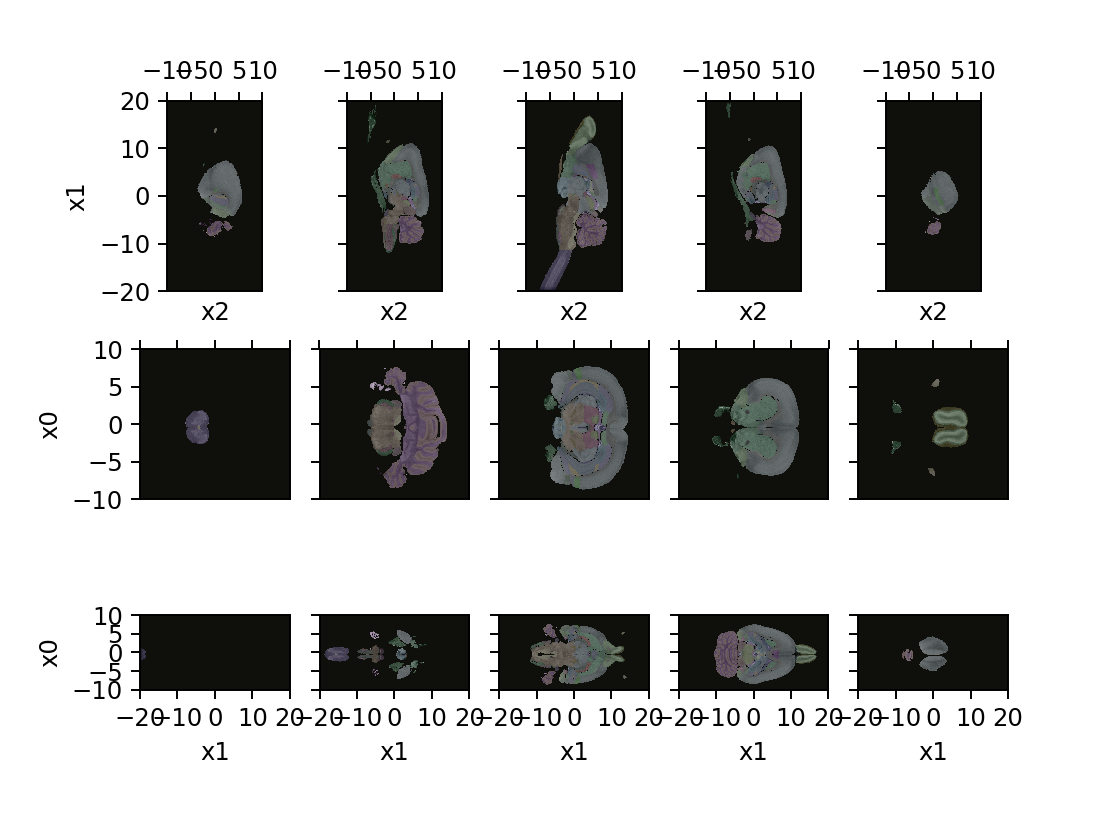

In [7]:
# show the labels
f = plt.figure()
vis.imshow_slices(vis.RGB_from_labels(L,I,alpha=0.125),x=xI,fig=f)
f.canvas.draw()

<IPython.core.display.Javascript object>


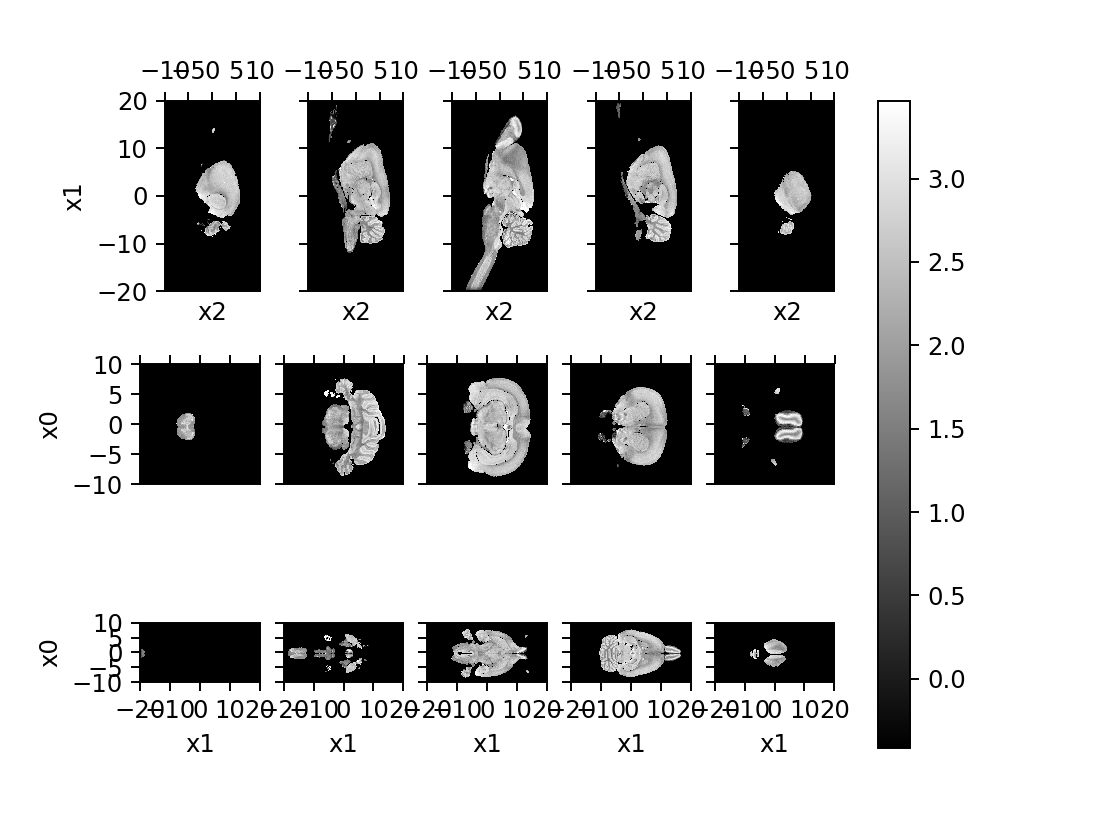

In [8]:
# display the atlas
f = plt.figure()
vis.imshow_slices(I,x=xI,fig=f,colorbar=True)
f.canvas.draw()

## Downsample to a working resolution

In [9]:
# downsample
I = lddmm.down(I.astype(float),atlas_downsample)
dxI = dxI*2.0
nxI = I.shape
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]

## Crop to a relevant subvolume

In [10]:
# crop?
x1lim = np.array([-6,13])
x1ind = ((x1lim - xI[1][0])/dxI[1]).astype(int)

Ic = np.array(I[:,x1ind[0]:x1ind[1]+1,:])
xIc = list(xI)
xIc[1] = xI[1][x1ind[0]:x1ind[1]+1]


<IPython.core.display.Javascript object>


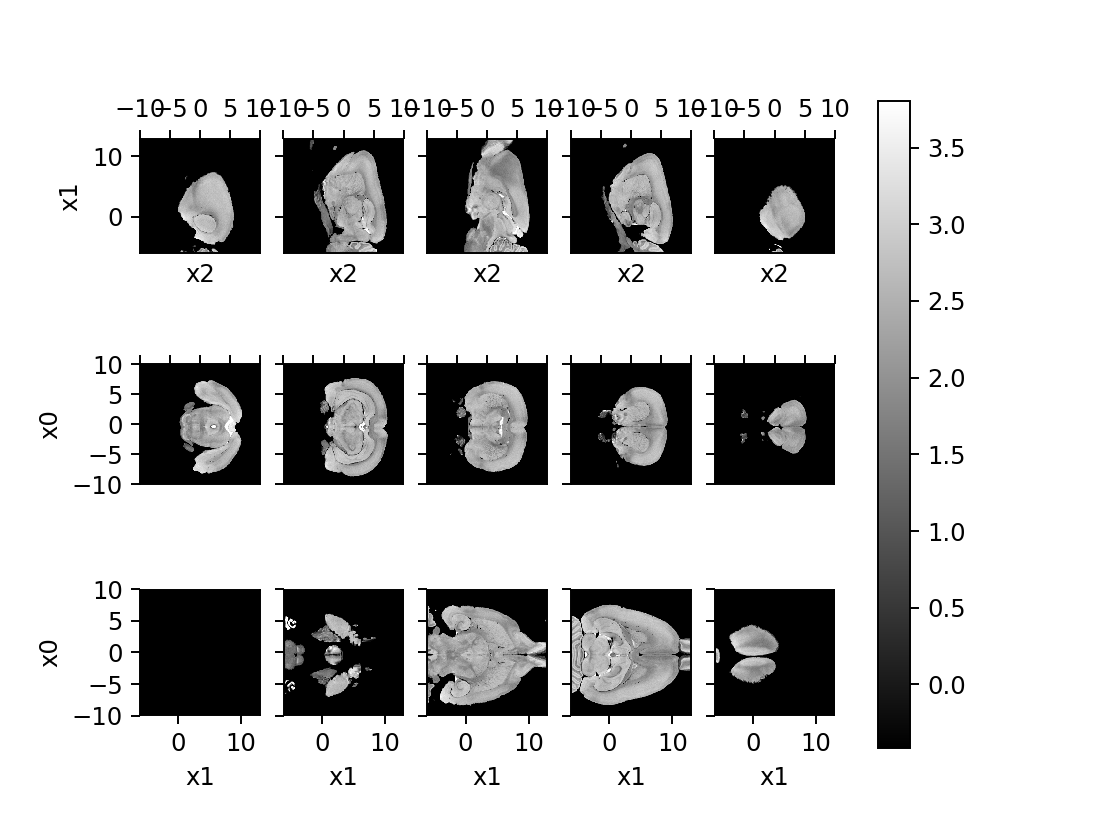

In [11]:
# display the atlas
f = plt.figure()
vis.imshow_slices(Ic,x=xIc,fig=f,colorbar=True)
f.canvas.draw()

# Input orientation
Look at the above figure and input orientation as a three character string (see above).

Characters must be L/R (left or right), A/P (anterior or posterior), S/I (superior or inferior)

The first character says the orientation of the positive x0 axis.

The second character says the orientation of the positive x1 axis.

The third character says the orientation of the positive x2 axis.

If there is ambiguity between left and right, we suggest using a right handed coordinate system.

Note that 'LAS' is a canonical coordinate system in MRI, even though it is not right handed.

In [12]:
atlas_orientation = 'LAS'

# Load data from tif files and preprocess

In [13]:
# get list of files
files = glob.glob(os.path.join(data_directory,'*.tif'))
files = list(sorted(files))
nfiles = len(files)

## Correct slice to slice intensity variations

In [14]:
def compute_intensity_correction(files):
    # get mean intensity
    means = np.zeros((nfiles))
    f,ax = plt.subplots()
    for i,fname in enumerate(files):    
        I_ = plt.imread(fname)    
        means[i] = np.mean(I_)
        if not i%10 or i == nfiles-1:
            ax.cla()
            ax.plot(means)
            ax.set_xlabel('Slice')
            ax.set_ylabel('Mean intensity')
            f.canvas.draw()   
    # smooth it
    npad = 100
    meansp = np.pad(means,npad,mode='reflect')
    # kernel
    r = 100
    k = np.exp(  -np.arange(-r,r+1)**2/2.0/(r/3.0)**2 )
    k /= np.sum(k)
    meansps = np.convolve(meansp,k,mode='same')
    meanss = meansps[npad:-npad]

    f,ax = plt.subplots()
    ax.plot(meanss)
    ax.set_xlabel('Slice')
    ax.set_ylabel('Corrected mean intensity')
    f.canvas.draw()
    correction = meanss/means
    return correction
    

<IPython.core.display.Javascript object>


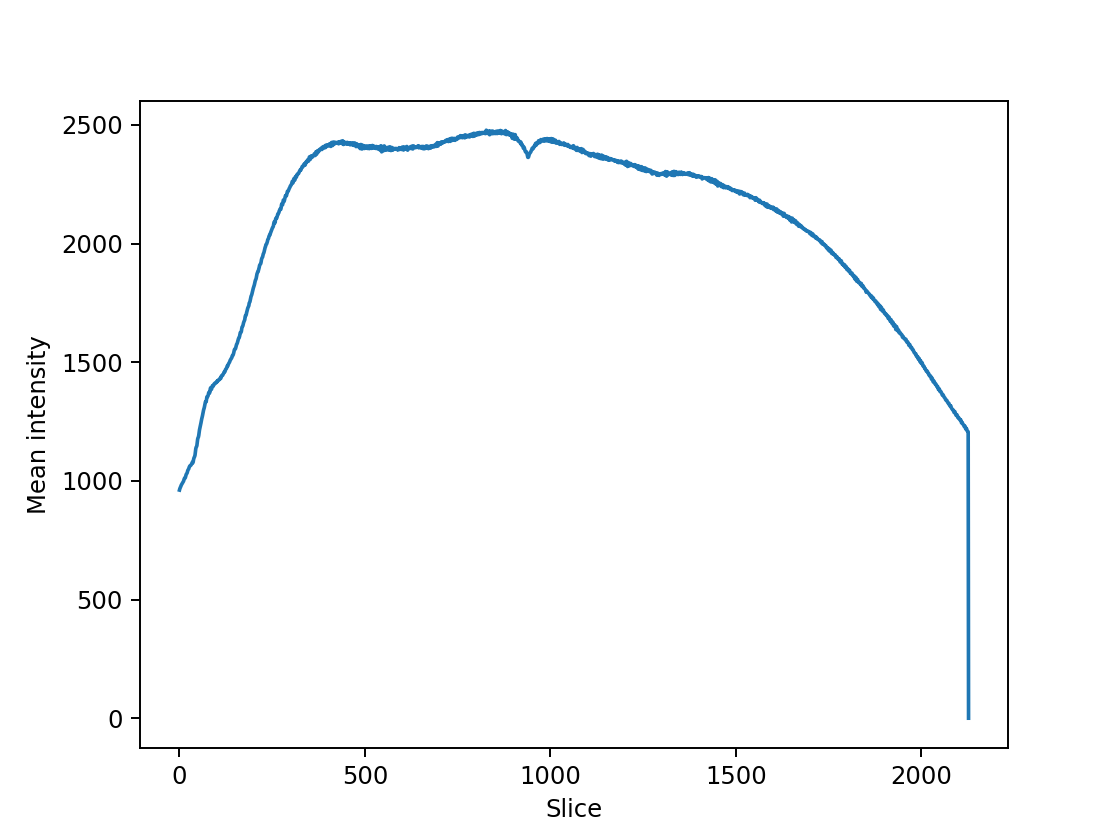

<IPython.core.display.Javascript object>


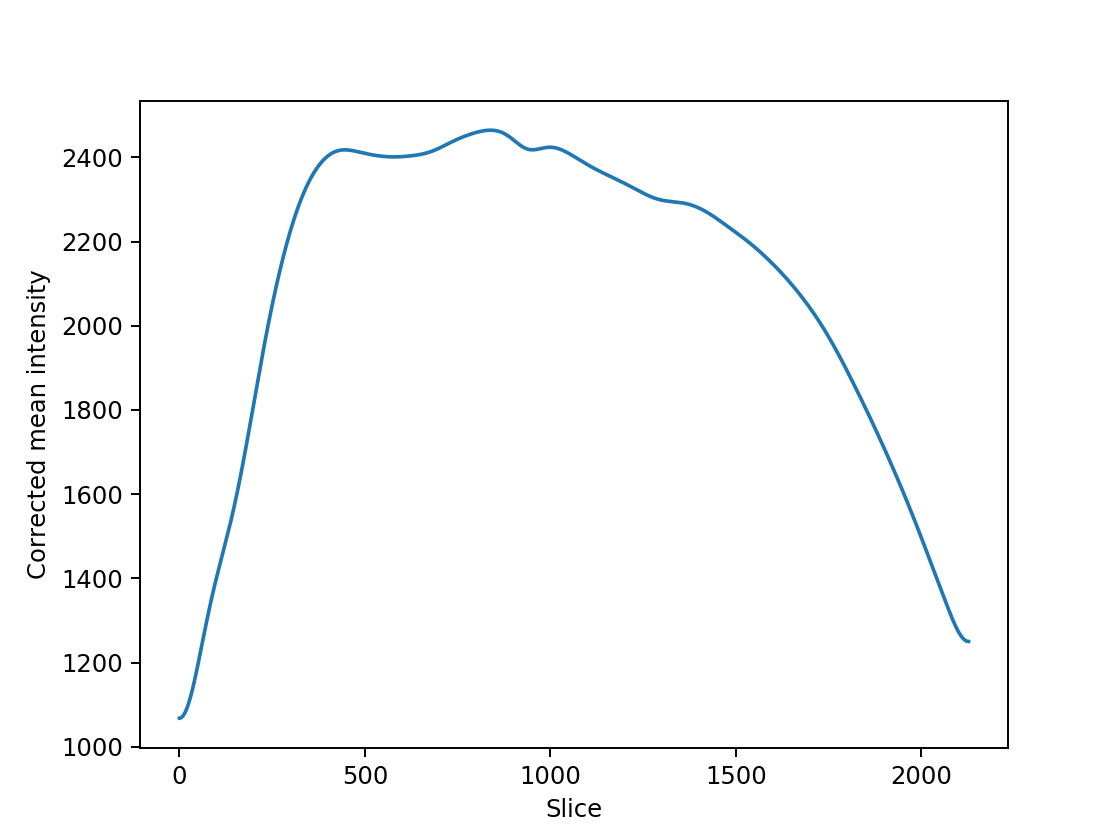

/cis/home/dtward/python-theta/ENV/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [15]:
correction = compute_intensity_correction(files)

## Clean shadowing artifacts and downsample

In [16]:
def make_centered_f(n,d):
    # frequency domain
    f0 = np.arange(n)/n/d
    # greater than Nyquist
    ind = f0 >= 1.0/2.0/d
    # shift
    f0 = np.concatenate([f0[ind]-1.0/d, f0[np.logical_not(ind)]])
    return f0

In [17]:
def filter_and_downsample(I_,dx,down,theta=10.5,correction=1.0,fig=None,draw=False):
    if draw:
        if fig is None:
            fig = plt.figure()
        fig.clf()
      
    
    nx = I_.shape    
    x = [np.arange(n)*d  for n,d in zip(nx,dx)]
    
    fx = [make_centered_f(n,d) for n,d in zip(nx,dx)]
    
    if draw:
        ax = fig.add_subplot(2,2,1)
        ax.imshow(I_,extent=[x[1][0],x[1][-1],x[0][0],x[0][-1]])
        ax.axis('off')
    
    if theta is not None:
        [F0,F1] = np.meshgrid(*fx, indexing='ij')
        FR,FT = np.sqrt(F0**2 + F1**2),np.arctan2(F1,F0)
        thetas = np.array([-theta,0.0,theta])
        thetas = np.concatenate([thetas,thetas-180,thetas+180])
        dtheta = 5.0
        slopetheta = 0.2
        sloper = 0.5
        high = 2.0

        FILT = np.ones_like(F0)
        highfilt = 1.0/(1.0 + np.exp(-(FR-high)/sloper))
        for t in thetas:
            thetafilt = 1.0/(1 + np.exp(-(FT/(np.pi/180) - (t-dtheta/2))/slopetheta))/(1 + np.exp(+(FT/(np.pi/180) - (t+dtheta/2))/slopetheta))        
            FILT = FILT * (1.0 - thetafilt*highfilt)

        Ihat = np.fft.fft2(I_)
        if draw:
            ax = fig.add_subplot(2,2,3)
            ax.imshow(np.fft.ifftshift(np.log(np.abs(Ihat) + 1.0)),extent=[fx[1][0],fx[1][-1],fx[0][0],fx[0][-1]])
            ax.axis('off')

        IhatF = np.fft.ifftshift(np.fft.fftshift(Ihat) * FILT)
        if draw:
            ax = fig.add_subplot(2,2,4)
            ax.imshow(np.fft.ifftshift(np.log(np.abs(IhatF) + 1.0)),extent=[fx[1][0],fx[1][-1],fx[0][0],fx[0][-1]])
            ax.axis('off')

        IF = np.fft.ifft2(IhatF).real
        
    else:
        IF = np.array(I_)
    if draw:
        ax = fig.add_subplot(2,2,2)
        ax.imshow(IF,extent=[x[1][0],x[1][-1],x[0][0],x[0][-1]])
        ax.axis('off')
    IFd = np.squeeze(lddmm.down(IF[:,:,None],[down[0],down[1],1]))
    return IFd

In [18]:
def downsampling_with_artifact_correction(files, data_downsample, theta=10.5, draw=10):
    '''
    Streak correction at angles specified by theta
    
    theta=None means no streak correction
    
    Downsample data by the triple data_downsample
    
    draw pictures every draw frames
    '''
    fig0 = plt.figure()
    fig1 = plt.figure()
    for i,fname in enumerate(files):
        I_ = plt.imread(fname)
        if i == 0:
            nxJ = np.array([I_.shape[0],I_.shape[1],len(files)]) // data_downsample
            J = np.zeros(nxJ)
        Id = filter_and_downsample(I_,(dx0,dx1),
                                   (data_downsample[0],data_downsample[1]),
                                   theta=None,
                                   correction=correction[i],fig=fig0,draw=not i%draw)
        fig0.suptitle('Slice {} of {}'.format(i,len(files)))
        this_slice = i//data_downsample[2]
        if this_slice == J.shape[2]:
            break
        J[:,:,this_slice] += Id/data_downsample[2]
        
        if not i%draw:
            fig1.clf()
            ax = fig1.add_subplot(1,2,1)
            ax.imshow(I_)
            ax.set_title('Original')
            ax.axis('off')
            ax = fig1.add_subplot(1,2,2)
            ax.imshow(J[:,:,this_slice])
            ax.set_title('Downsampled')
            ax.axis('off')

            fig0.canvas.draw()
            fig1.canvas.draw()
    return J


<IPython.core.display.Javascript object>


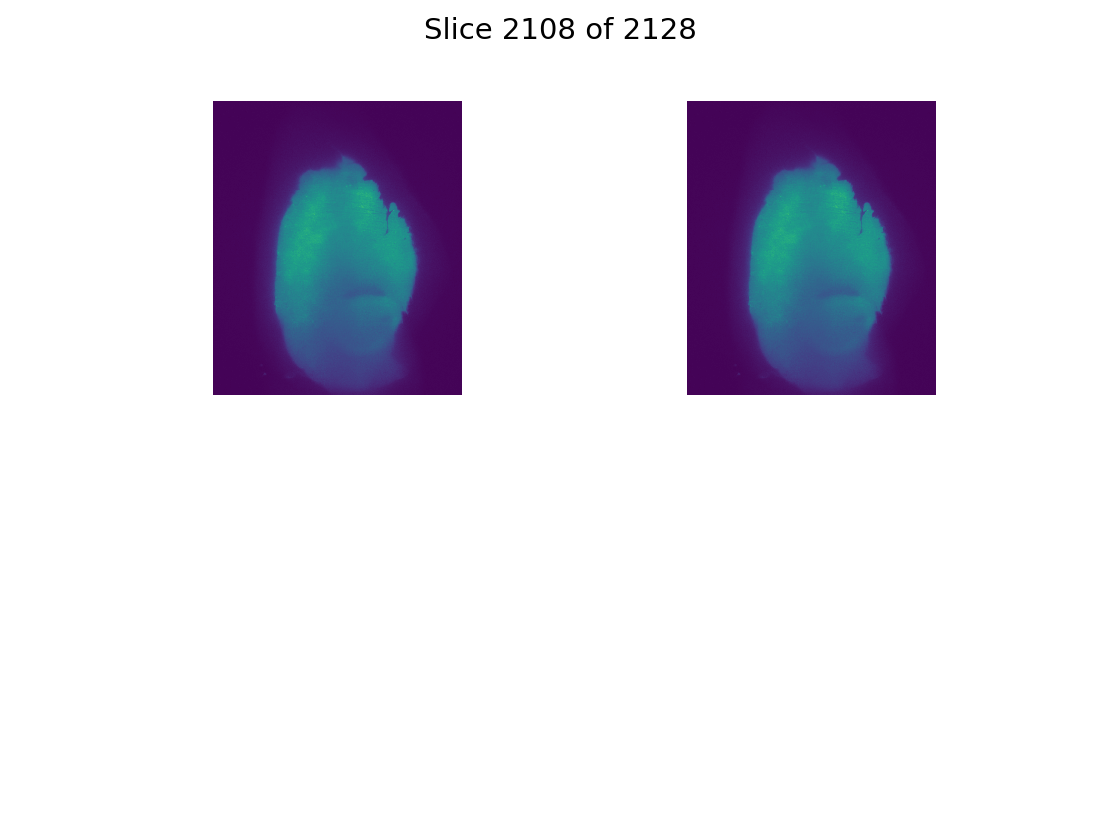

<IPython.core.display.Javascript object>


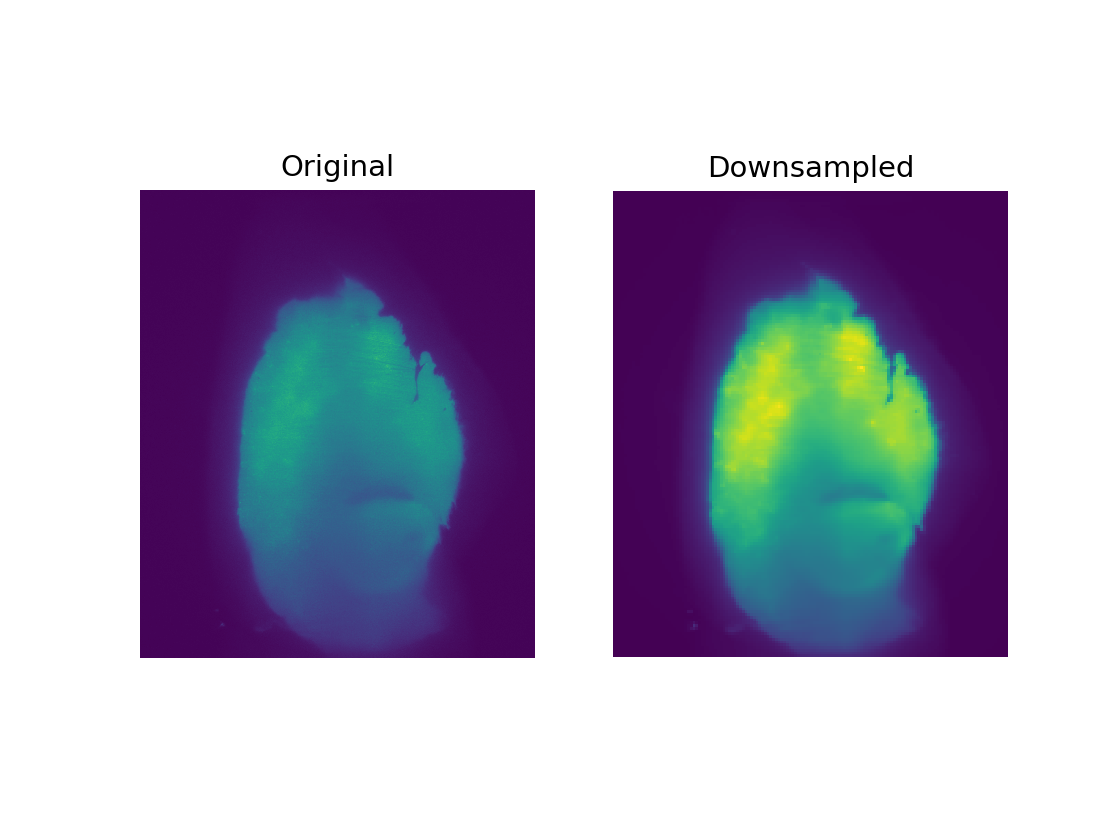

In [19]:
J = downsampling_with_artifact_correction(files,data_downsample,theta=None)

In [20]:
# save this image J
nxJ = J.shape
dxJ = np.array([dx0,dx1,dx2])*data_downsample
img = nib.Nifti1Image(J, np.diag([dxJ[0],dxJ[1],dxJ[2],1]))
img.get_data_dtype() 
img.to_filename(os.path.join(output_directory,'J.nii.gz'))


# Load 3D target image

## Skip preprocessing above if you already have a saved 3D image

In [21]:
# load the saved image (or skip the above preprocessing and go directly here)
img_target = nib.load(os.path.join(output_directory,'J.nii.gz'))
J = img_target.get_data()
nxJ = img_target.header['dim'][1:4]
dxJ = img_target.header['pixdim'][1:4]
xJ = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJ,dxJ)]

<IPython.core.display.Javascript object>


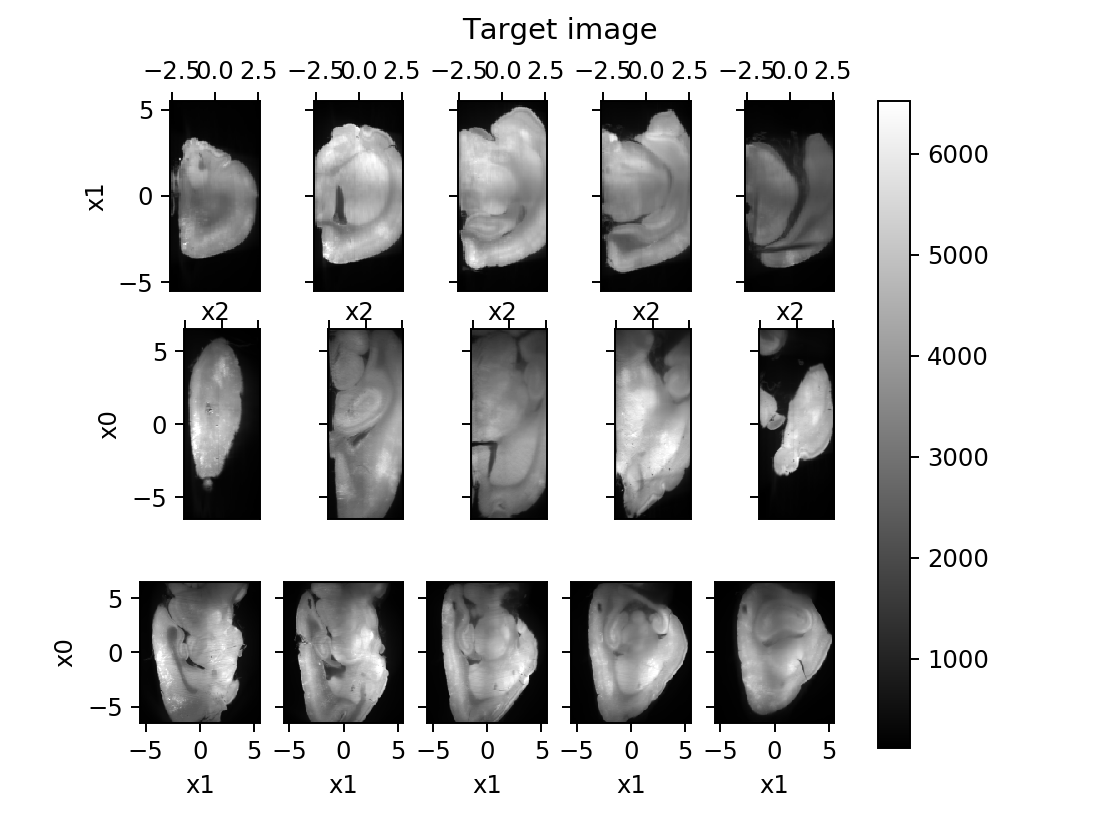

In [22]:
# display the target
f = plt.figure()
vis.imshow_slices(J,x=xJ,fig=f,colorbar=True)
f.suptitle('Target image')
f.canvas.draw()

# Input orientation
Look at the above figure and input orientation as a three character string (see above).

If there is ambiguity, we suggest using a right handed coordinate system (or the same system as above).


In [23]:
target_orientation = 'PIL'

# Verify the 3D orientation matches the atlas

<IPython.core.display.Javascript object>


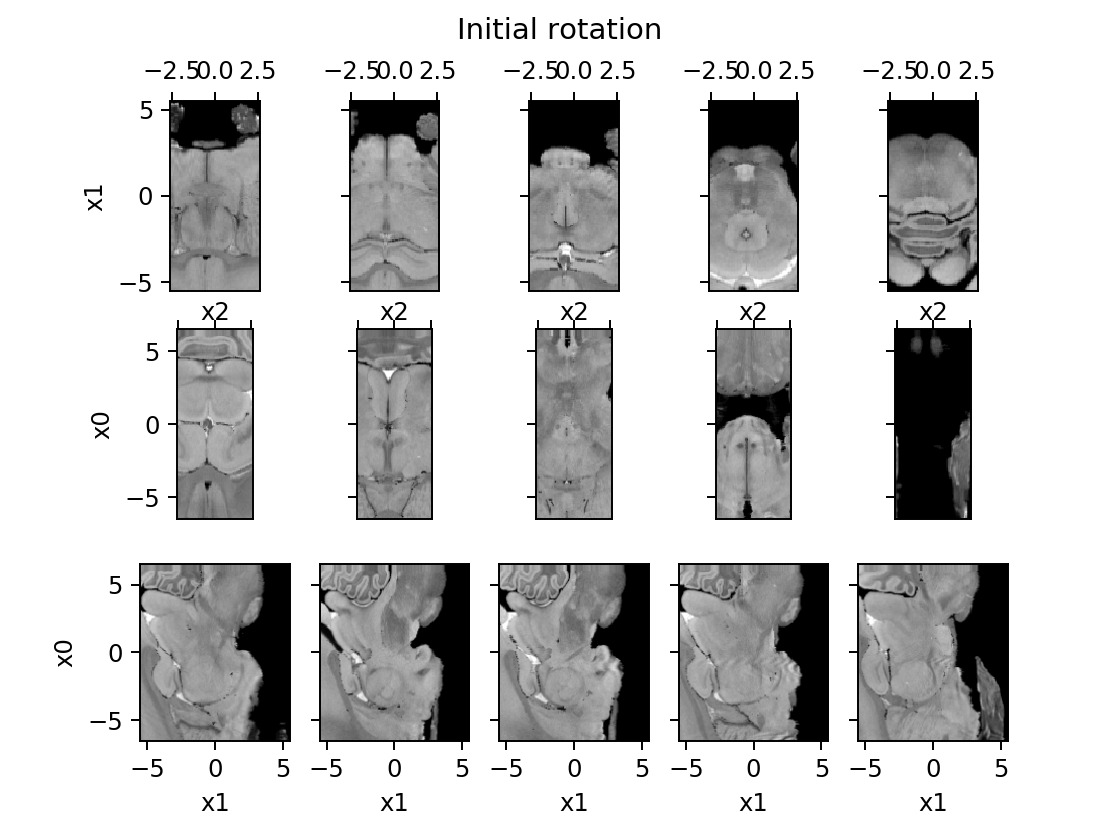

In [24]:
# input orientation
A = lddmm.orientation_to_matrix(atlas_orientation, target_orientation)

Id = lddmm.affine_transform_data(*xIc,Ic,A,*xJ)
f = plt.figure()
vis.imshow_slices(Id,x=xJ,fig=f)
f.suptitle('Initial rotation')
f.canvas.draw()


<IPython.core.display.Javascript object>


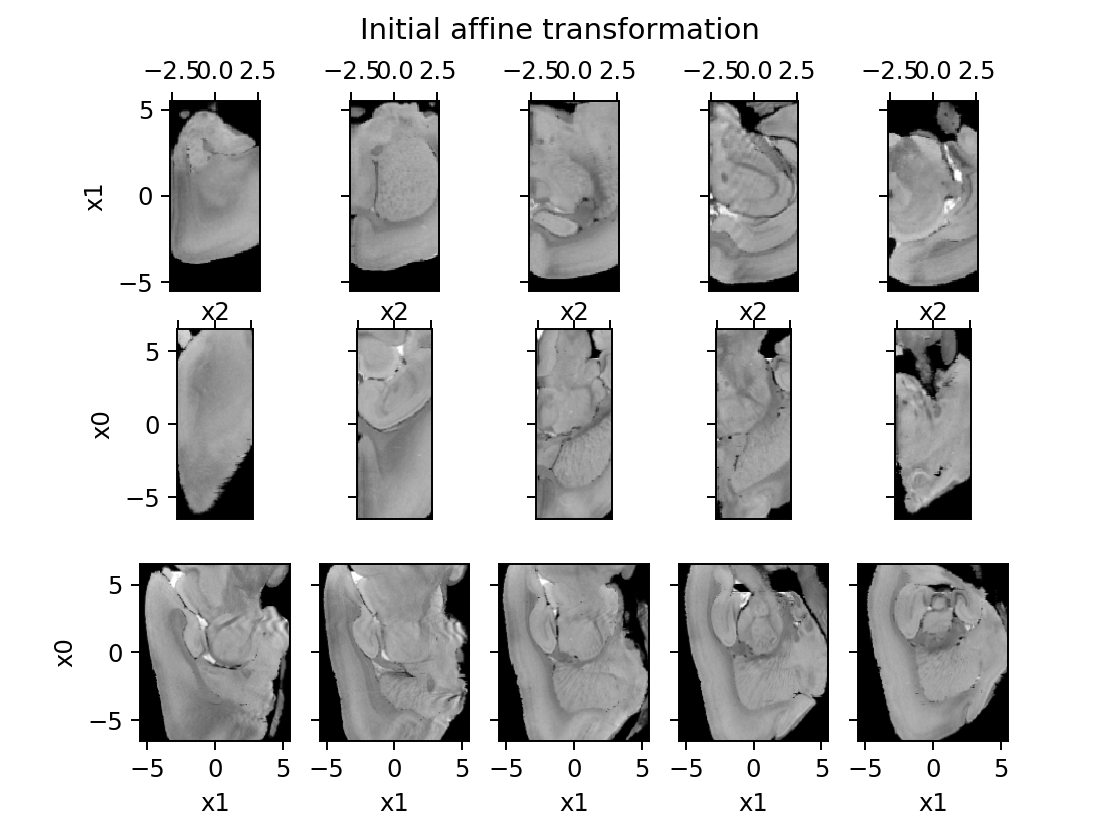

In [25]:
# shift since we are matching one hemisphere
shift = [3,2,-2]
A = np.array([[1,0,0,shift[0]],
             [0,1,0,shift[1]],
             [0,0,1,shift[2]],
             [0,0,0,1]])@A
Id = lddmm.affine_transform_data(*xIc,Ic,A,*xJ)
f = plt.figure()
vis.imshow_slices(Id,x=xJ,fig=f)
f.suptitle('Initial affine transformation')
f.canvas.draw()

## Inhomogeneity correction 
This is essential, either part of matching code or as a preprocessing step.

<IPython.core.display.Javascript object>


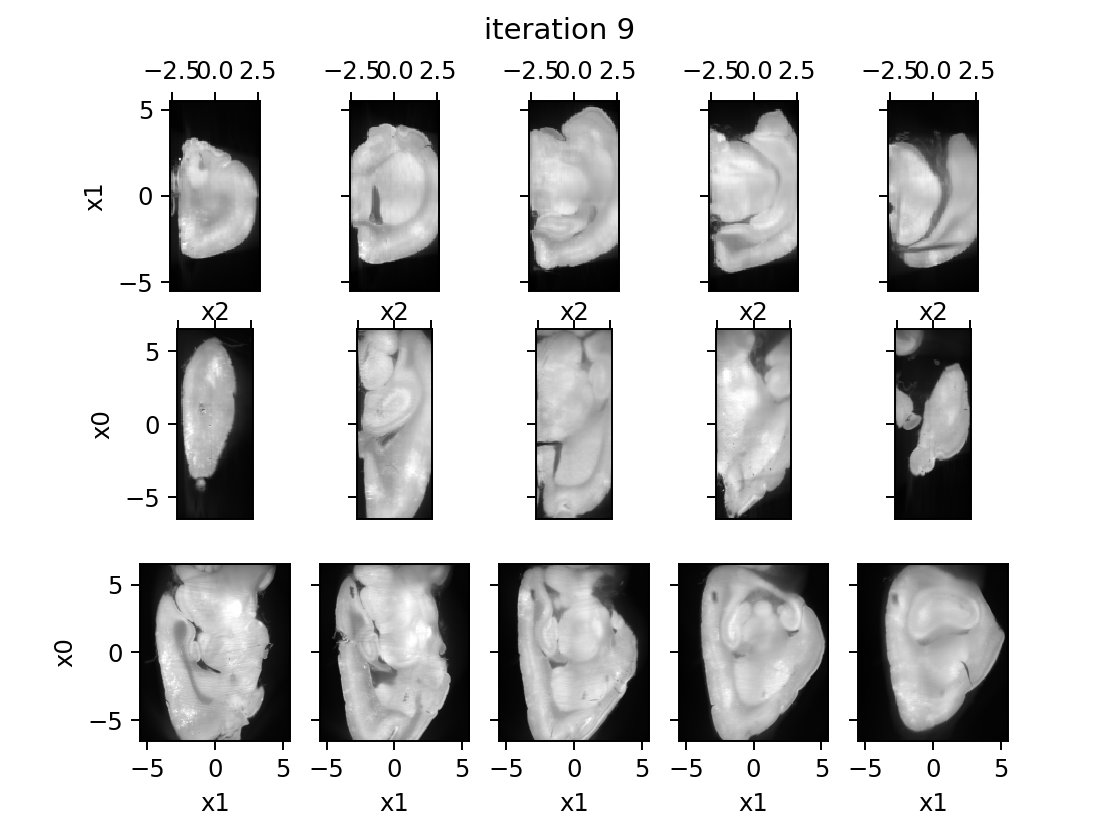

<IPython.core.display.Javascript object>


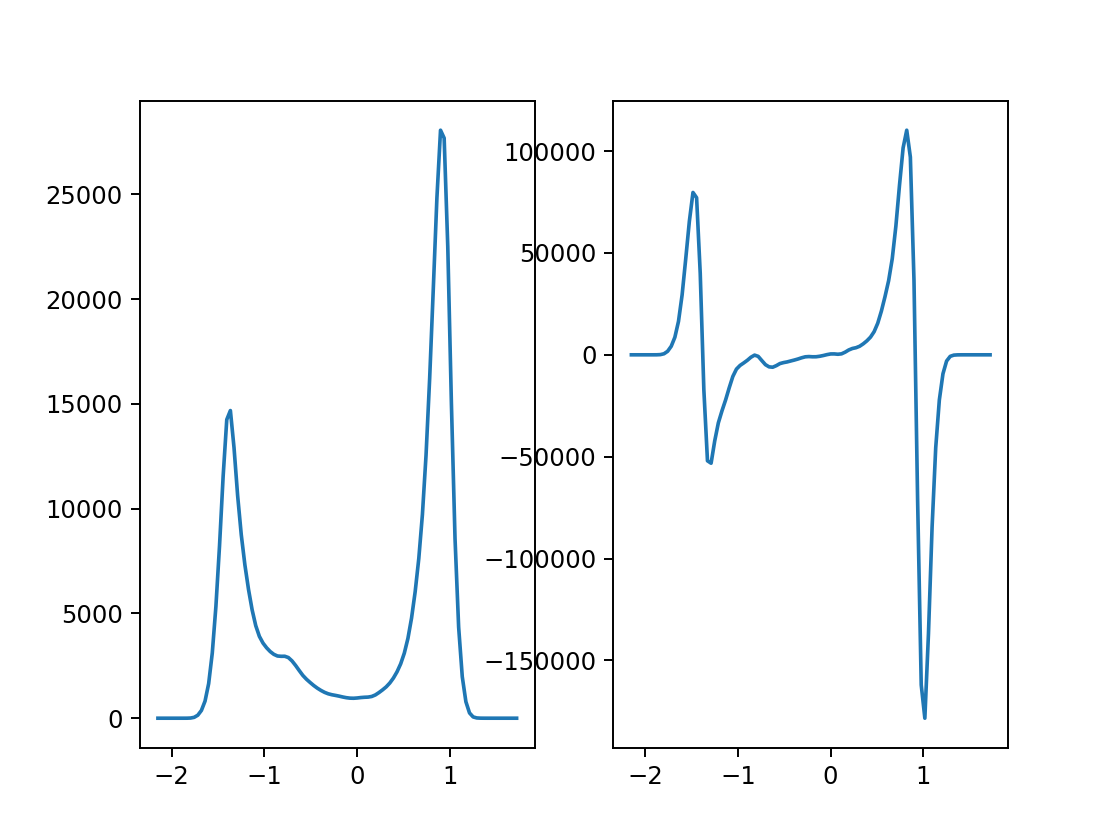

/cis/home/dtward/python-theta/ENV/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [26]:
Jc = rit.nonuniformity_corrrection(xJ, J)

# Run the registration at increasing resolution

## First run downsampled by 4

In [27]:
# downsample data
ndown = 2
dxId = np.array(dxI)
dxJd = np.array(dxJ)
Id = np.array(Ic)
Jd = np.array(Jc)
for d in range(ndown):
    # downsample
    Id = lddmm.down2(Id.astype(float))
    dxId = dxId*2.0
    
    Jd = lddmm.down2(Jd.astype(float))
    dxJd = dxJd*2.0

nxId = Id.shape
down = 2**ndown
xId = [xIc[0][::down] + dxId[0]/2.0, xIc[1][::down] + dxId[1]/2.0, xIc[2][::down] + dxId[2]/2.0] 

nxJd = Jd.shape
xJd = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJd,dxJd)]

Set default parameters
Initial affine transform [[ 0. -1.  0.  3.]
 [ 0.  0. -1.  2.]
 [ 1.  0.  0. -2.]
 [ 0.  0.  0.  1.]]
Got parameters


<IPython.core.display.Javascript object>


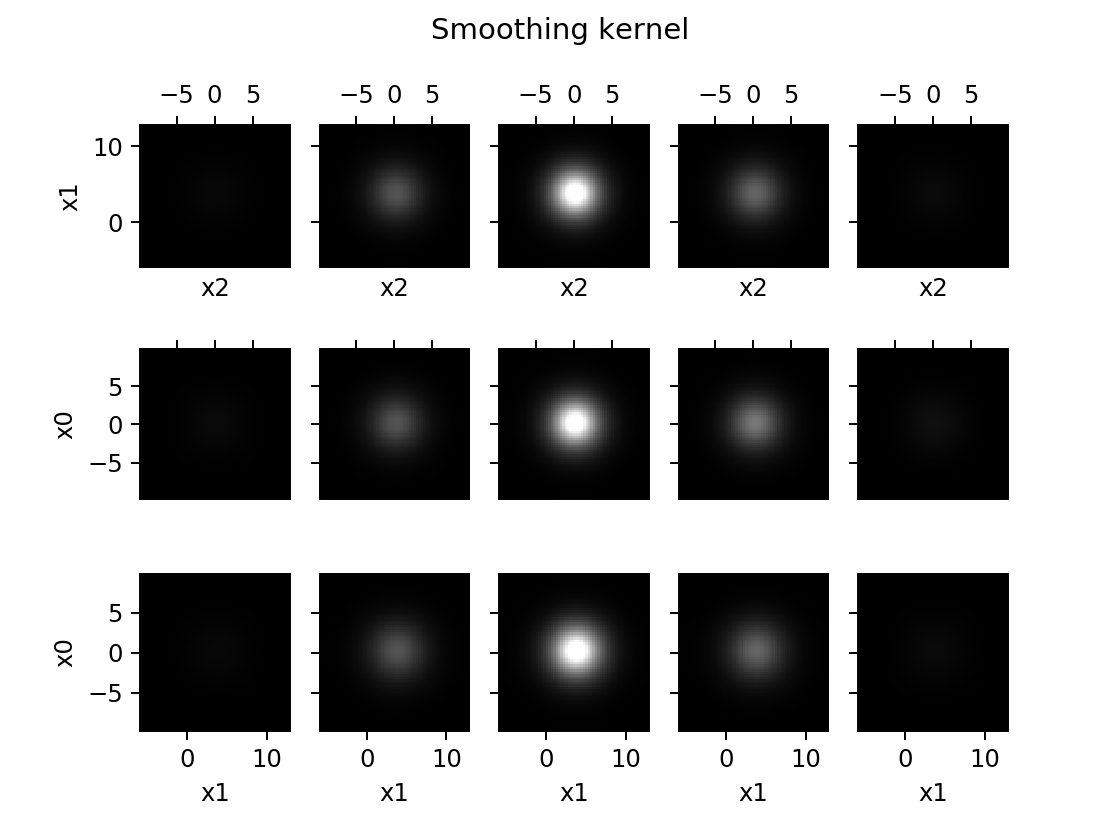

Built energy operators
Instructions for updating:
Colocations handled automatically by placer.
Built tensorflow variables
Computation graph defined


<IPython.core.display.Javascript object>


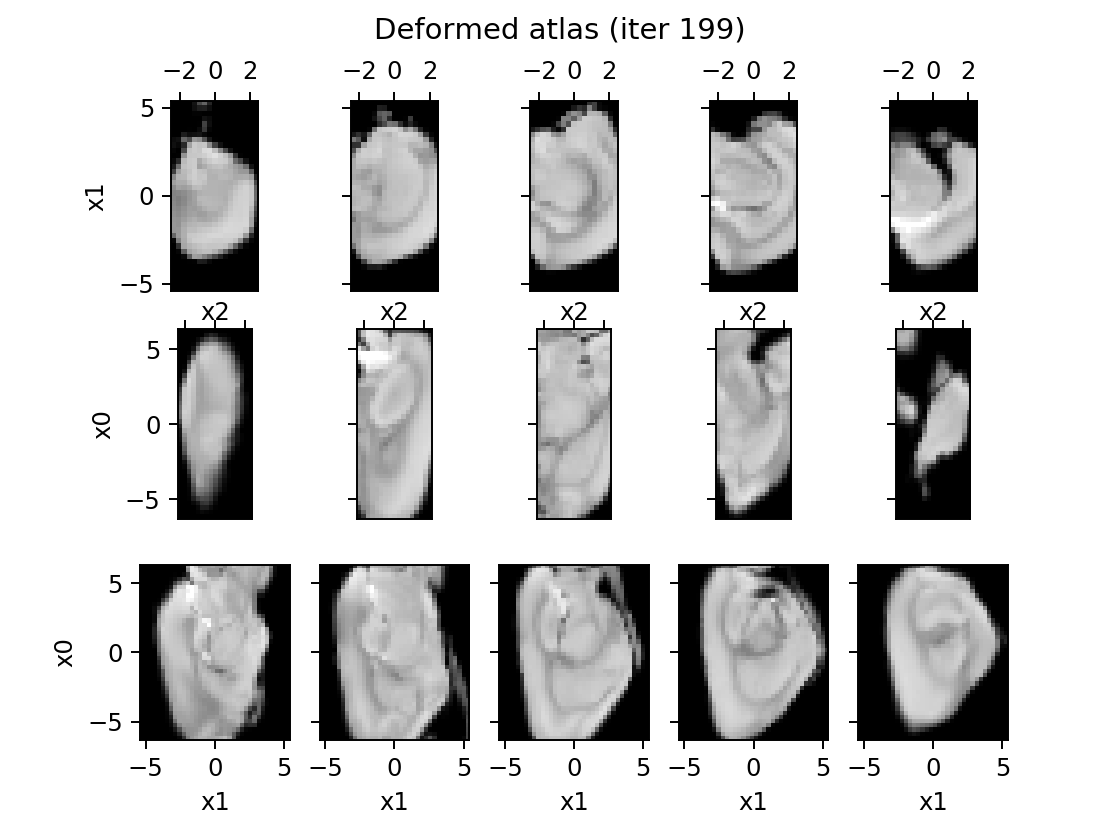

<IPython.core.display.Javascript object>


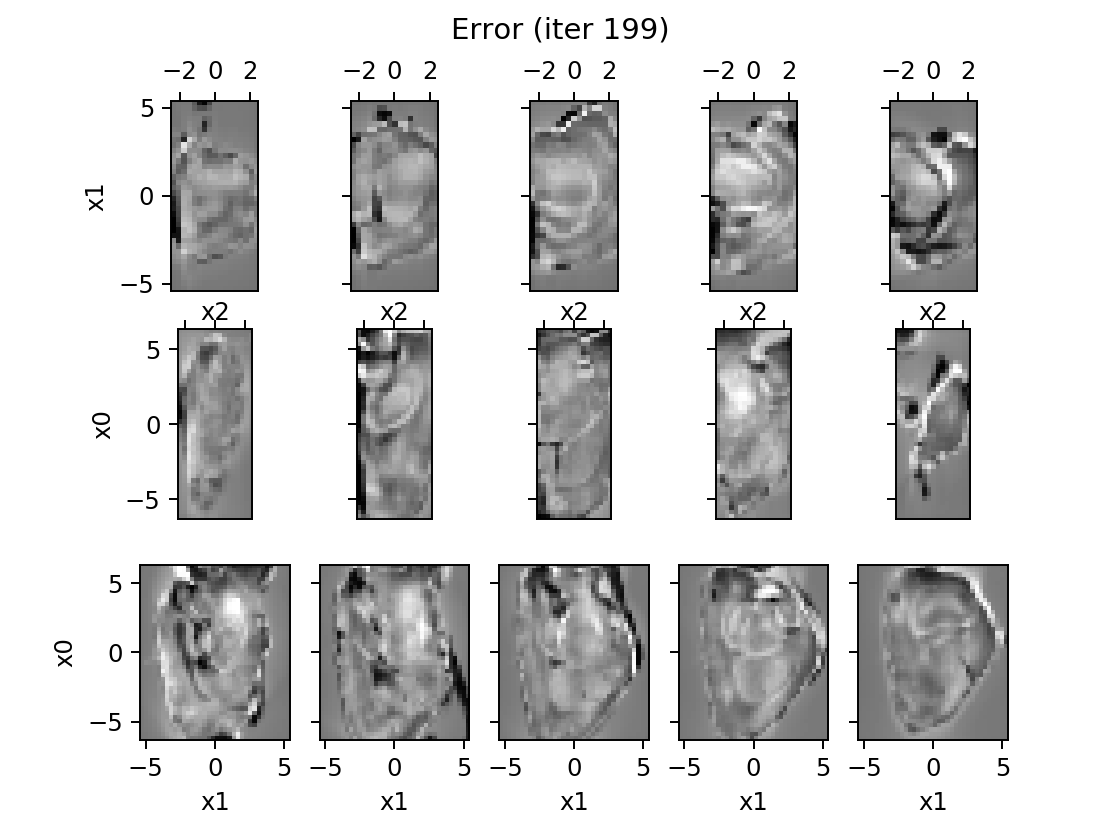

<IPython.core.display.Javascript object>


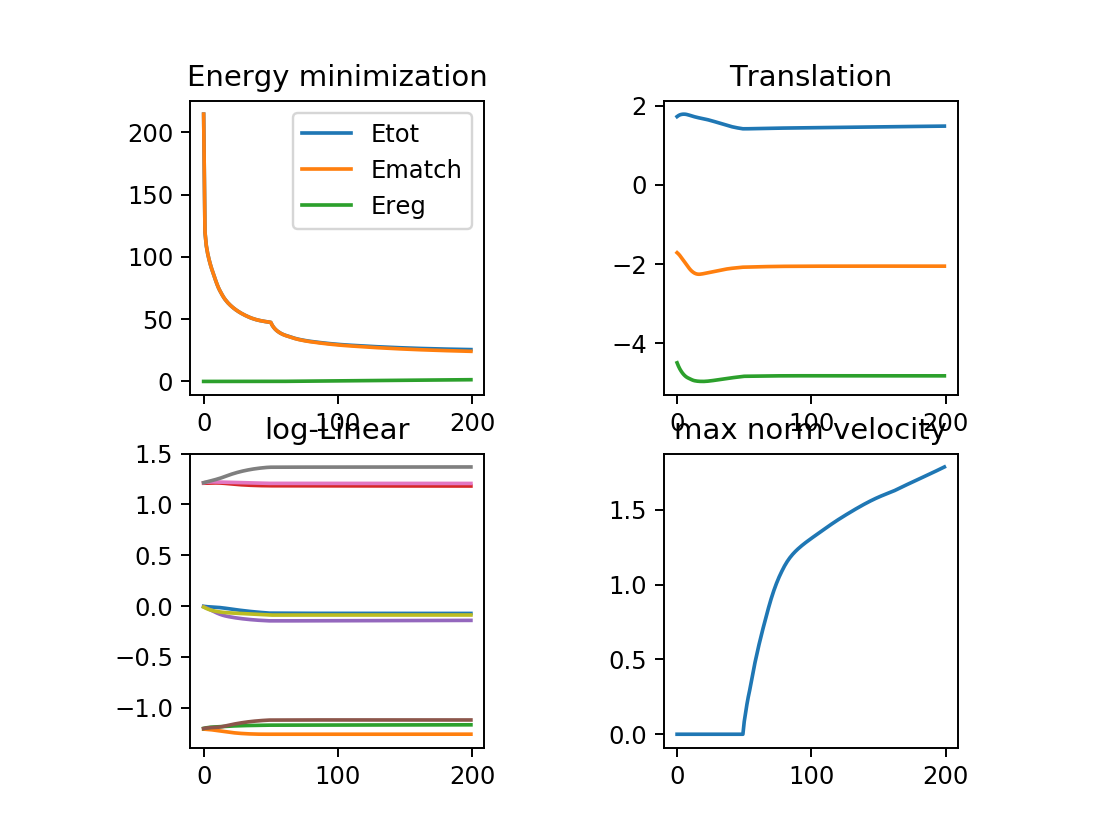

<IPython.core.display.Javascript object>


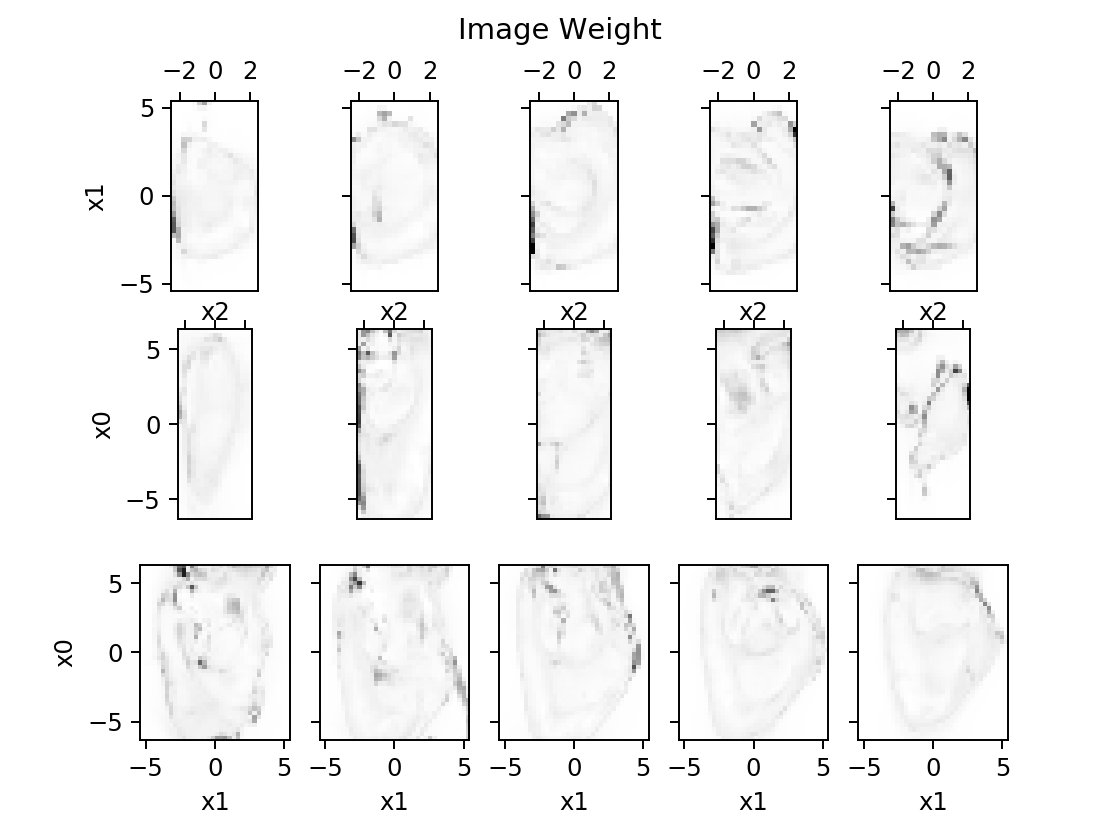

<IPython.core.display.Javascript object>


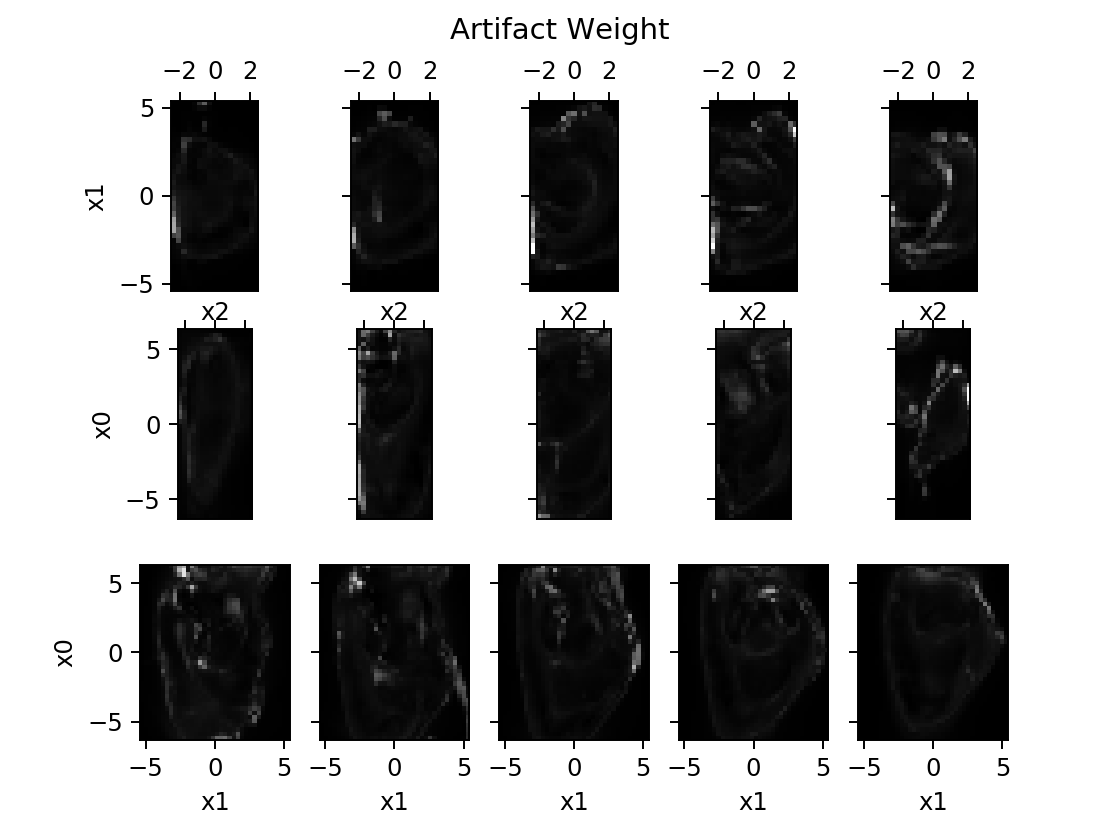

Taking affine only step
Updating weights


/cis/home/dtward/python-theta/ENV/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Finished iteration 0, energy 2.144949e+02 (match 2.144949e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
Finished iteration 1, energy 1.198300e+02 (match 1.198300e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
Finished iteration 2, energy 1.088523e+02 (match 1.088523e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
Finished iteration 3, energy 1.026817e+02 (match 1.026817e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
Finished iteration 4, energy 9.796746e+01 (match 9.796746e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
Finished iteration 5, energy 9.391596e+01 (match 9.391596e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
Finished iteration 6, energy 9.033257e+01 (match 9.033257e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
Finished iteration 7, energy 8.711175e+01 (match 8.711175e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
Finished iteration 8, en

Updating weights
Finished iteration 66, energy 3.519910e+01 (match 3.506056e+01, reg 1.385380e-01)
Taking affine and deformation step
Updating weights
Finished iteration 67, energy 3.486976e+01 (match 3.472024e+01, reg 1.495167e-01)
Taking affine and deformation step
Updating weights
Finished iteration 68, energy 3.456021e+01 (match 3.439970e+01, reg 1.605157e-01)
Taking affine and deformation step
Updating weights
Finished iteration 69, energy 3.427230e+01 (match 3.410083e+01, reg 1.714726e-01)
Taking affine and deformation step
Updating weights
Finished iteration 70, energy 3.400628e+01 (match 3.382394e+01, reg 1.823487e-01)
Taking affine and deformation step
Updating weights
Finished iteration 71, energy 3.375961e+01 (match 3.356648e+01, reg 1.931223e-01)
Taking affine and deformation step
Updating weights
Finished iteration 72, energy 3.353276e+01 (match 3.332898e+01, reg 2.037786e-01)
Taking affine and deformation step
Updating weights
Finished iteration 73, energy 3.332384e+01 (m

Updating weights
Finished iteration 127, energy 2.795904e+01 (match 2.723533e+01, reg 7.237094e-01)
Taking affine and deformation step
Updating weights
Finished iteration 128, energy 2.790606e+01 (match 2.717312e+01, reg 7.329445e-01)
Taking affine and deformation step
Updating weights
Finished iteration 129, energy 2.785424e+01 (match 2.711206e+01, reg 7.421809e-01)
Taking affine and deformation step
Updating weights
Finished iteration 130, energy 2.780225e+01 (match 2.705083e+01, reg 7.514211e-01)
Taking affine and deformation step
Updating weights
Finished iteration 131, energy 2.774995e+01 (match 2.698929e+01, reg 7.606616e-01)
Taking affine and deformation step
Updating weights
Finished iteration 132, energy 2.769870e+01 (match 2.692880e+01, reg 7.699018e-01)
Taking affine and deformation step
Updating weights
Finished iteration 133, energy 2.764849e+01 (match 2.686934e+01, reg 7.791435e-01)
Taking affine and deformation step
Updating weights
Finished iteration 134, energy 2.75989

Updating weights
Finished iteration 188, energy 2.578111e+01 (match 2.449348e+01, reg 1.287632e+00)
Taking affine and deformation step
Updating weights
Finished iteration 189, energy 2.575997e+01 (match 2.446309e+01, reg 1.296883e+00)
Taking affine and deformation step
Updating weights
Finished iteration 190, energy 2.573908e+01 (match 2.443295e+01, reg 1.306136e+00)
Taking affine and deformation step
Updating weights
Finished iteration 191, energy 2.571862e+01 (match 2.440323e+01, reg 1.315390e+00)
Taking affine and deformation step
Updating weights
Finished iteration 192, energy 2.569839e+01 (match 2.437375e+01, reg 1.324646e+00)
Taking affine and deformation step
Updating weights
Finished iteration 193, energy 2.567807e+01 (match 2.434417e+01, reg 1.333901e+00)
Taking affine and deformation step
Updating weights
Finished iteration 194, energy 2.565795e+01 (match 2.431480e+01, reg 1.343159e+00)
Taking affine and deformation step
Updating weights
Finished iteration 195, energy 2.56380

In [28]:
# Calculate affine transform and deformation at low resolution
naffine = 50
niter = 200
sigmaM = 0.5
sigmaA = sigmaM*5.0

#EM algorithm
nMstep = 1
nMstep_affine = 1

# matching cost
sigmaM = 1.0

# affine gradient descent step sizes
eT = 1e-3*sigmaM**2
eL = 1e-5*sigmaM**2

# and for deformation
nt = 5 # timesteps for flow
a = 2.0 # in millimeters, not voxels
a = 1.0 # I think 2 was too big
eV = 5e0*sigmaM**2
sigmaR = 5e1
# now that I made a smaller
# we need a smaller stepsize
eV = 2e0
eV = 1e0

# run mapping at low res
outd2 = lddmm.lddmm(Id,Jd,
                    xI=xId,xJ=xJd,
                    A0=A,
                    niter=niter, naffine=naffine,
                    eT=eT*down, eL=eL*down,
                    nMstep=nMstep, nMstep_affine=nMstep_affine,
                    sigmaM=sigmaM,sigmaA=sigmaA,
                    sigmaR=sigmaR, eV=eV*down, a=a, nt=nt
                   )

## Now run downsampled by 2

In [29]:
# go to higher resolution
# downsample data
ndown = 1
dxId = np.array(dxI)
dxJd = np.array(dxJ)
Id = np.array(Ic)
Jd = np.array(Jc)
for d in range(ndown):
    # downsample
    Id = lddmm.down2(Id.astype(float))
    dxId = dxId*2.0
    
    Jd = lddmm.down2(Jd.astype(float))
    dxJd = dxJd*2.0

nxId = Id.shape
down = 2**ndown
xId = [xIc[0][::down] + dxId[0]/2.0, xIc[1][::down] + dxId[1]/2.0, xIc[2][::down] + dxId[2]/2.0] 

nxJd = Jd.shape
xJd = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJd,dxJd)]

Set default parameters
Initial affine transform [[ 0.00336063 -0.94581866 -0.00693383  3.0993996 ]
 [ 0.0111187  -0.05948252 -0.8227812   1.6955974 ]
 [ 0.95140344  0.02051597 -0.01633557 -2.4449315 ]
 [ 0.          0.          0.          1.        ]]
Upsampling velocity time 0 of 5


/cis/home/dtward/Documents/image_lddmm_tensorflow/lddmm.py:329: UserWarning: upsampling initial guess of velocity field
  warnings.warn('upsampling initial guess of velocity field')


Upsampling velocity time 1 of 5
Upsampling velocity time 2 of 5
Upsampling velocity time 3 of 5
Upsampling velocity time 4 of 5
Got parameters


<IPython.core.display.Javascript object>


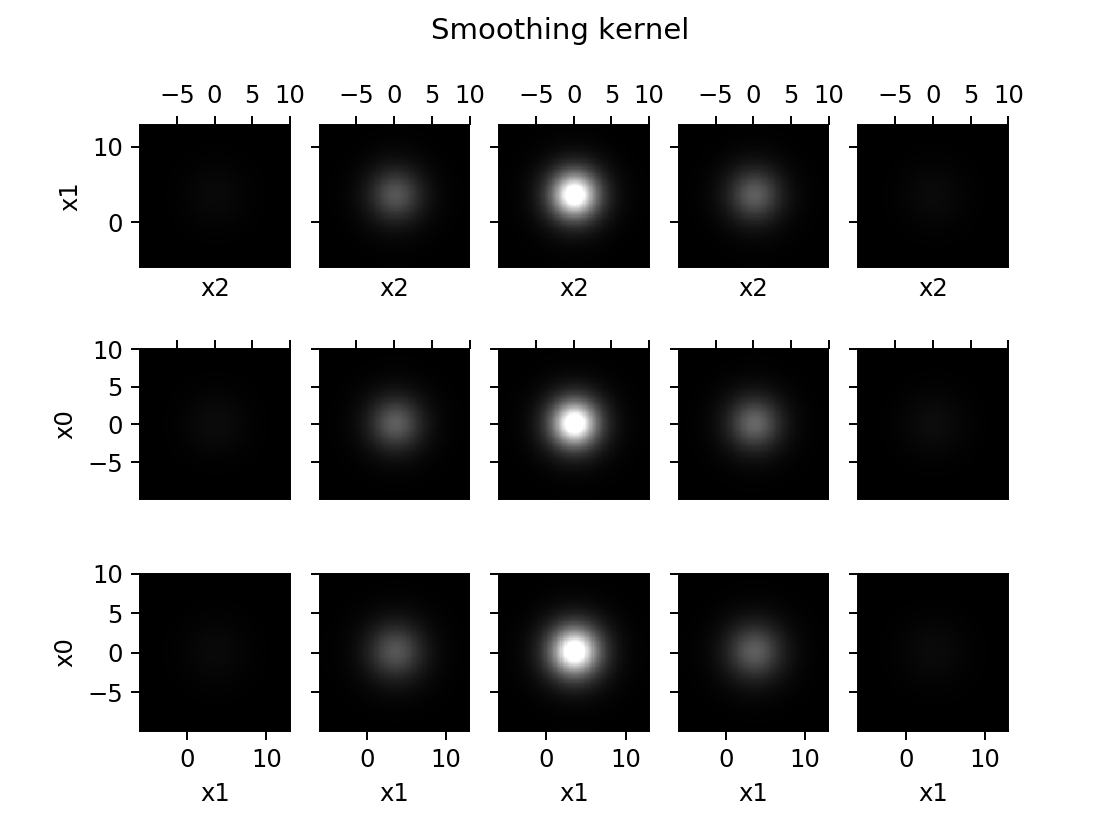

Built energy operators
Built tensorflow variables
Computation graph defined


<IPython.core.display.Javascript object>


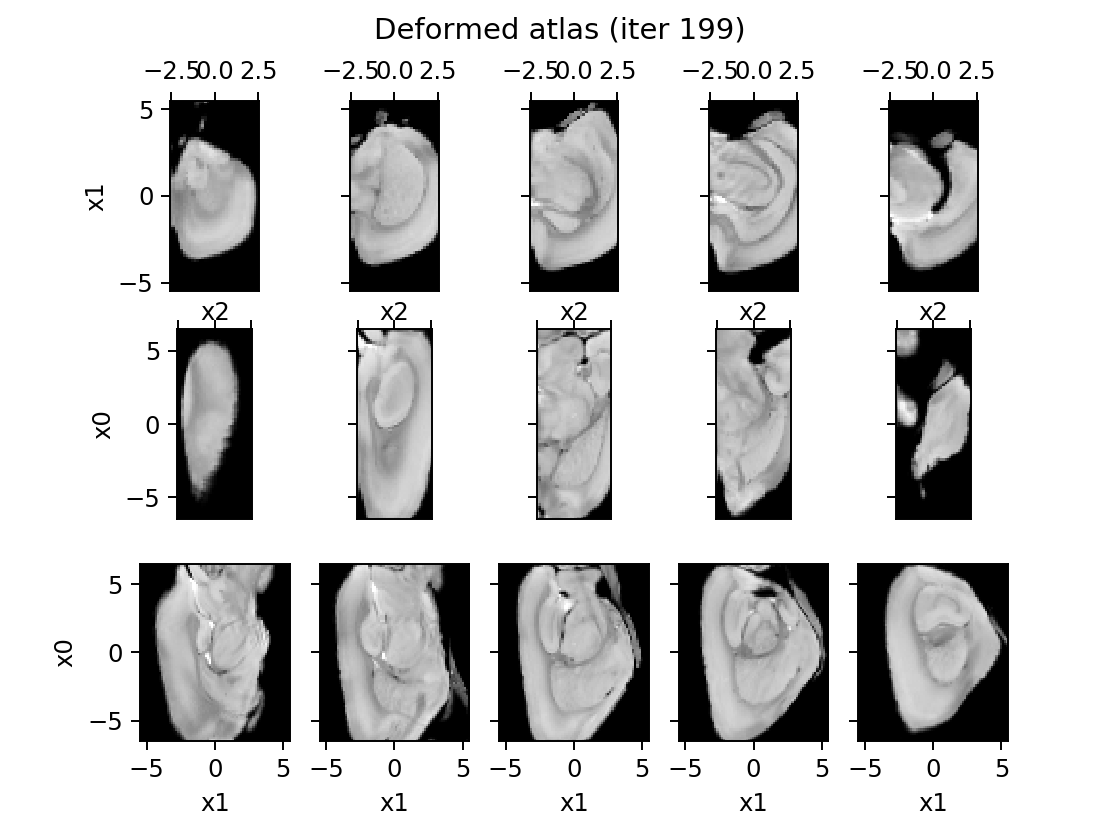

/cis/home/dtward/python-theta/ENV/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


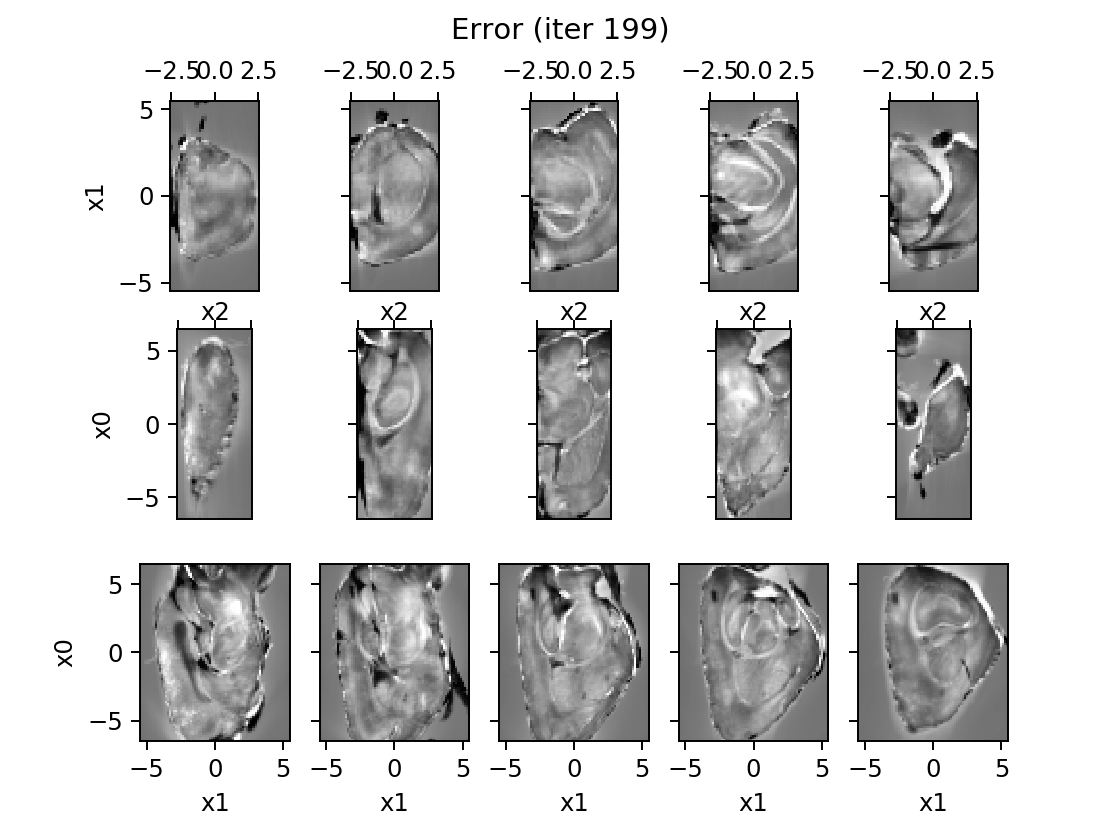

<IPython.core.display.Javascript object>


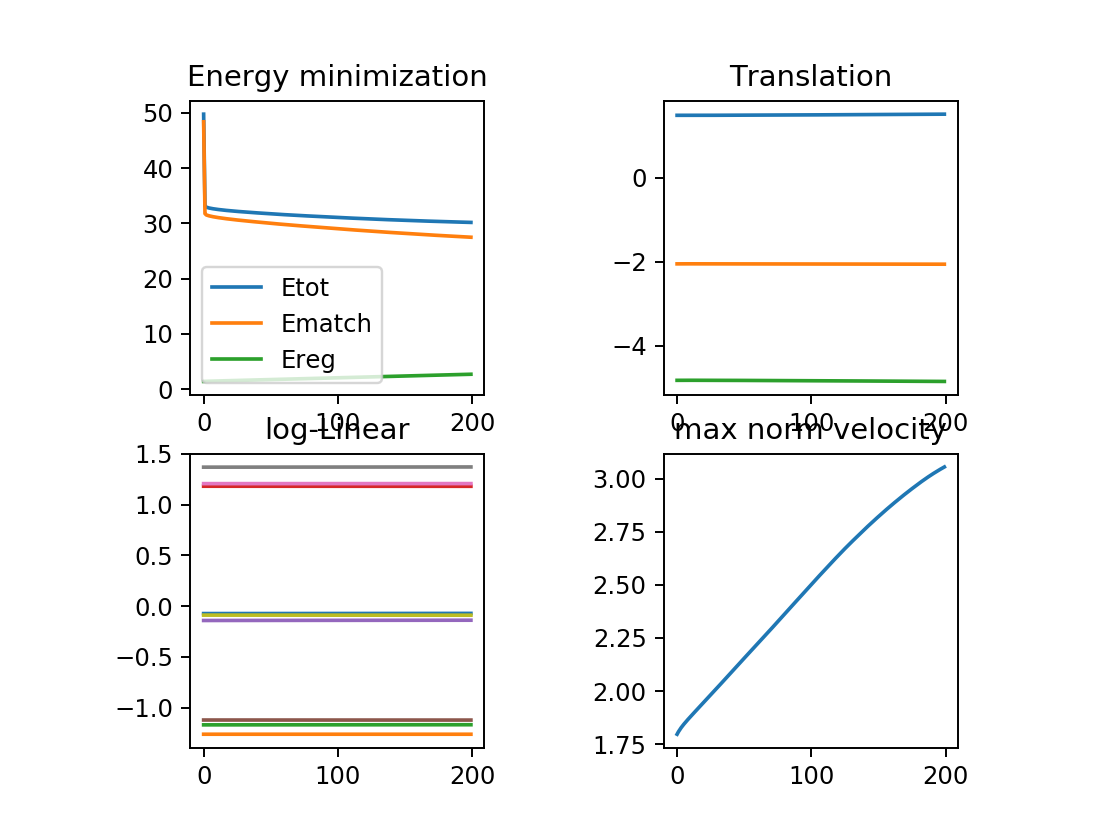

<IPython.core.display.Javascript object>


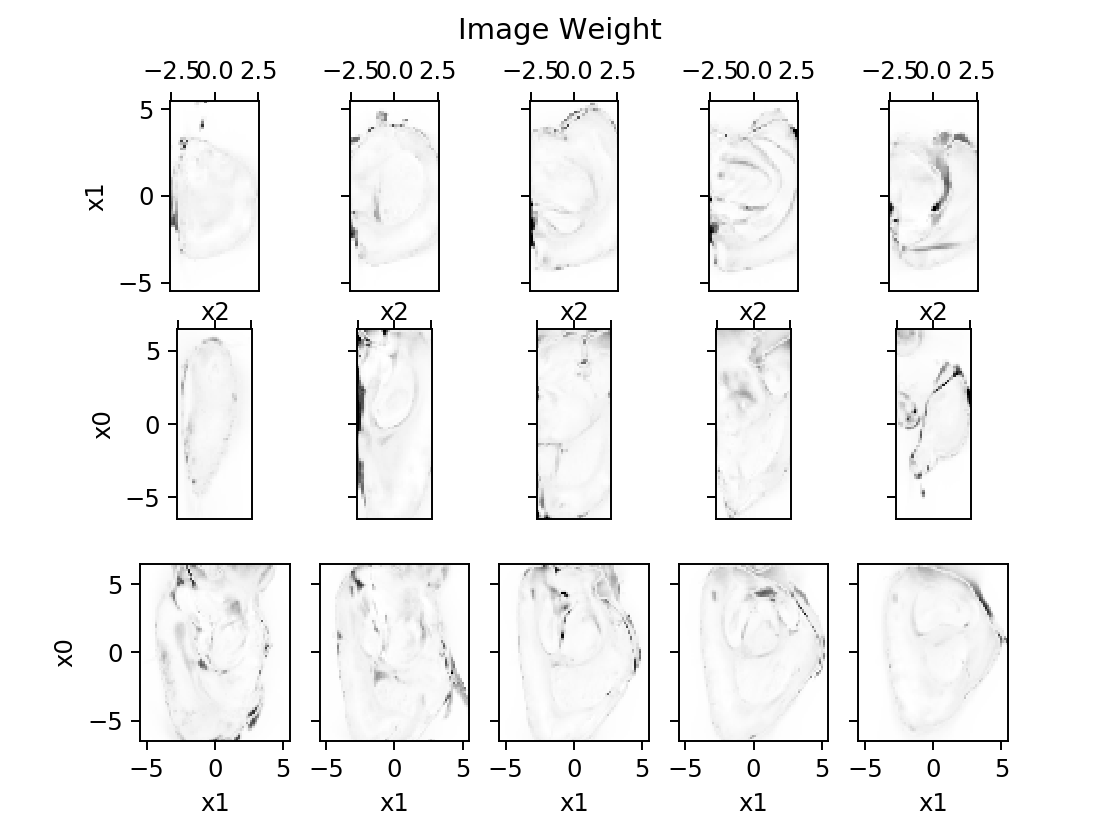

<IPython.core.display.Javascript object>


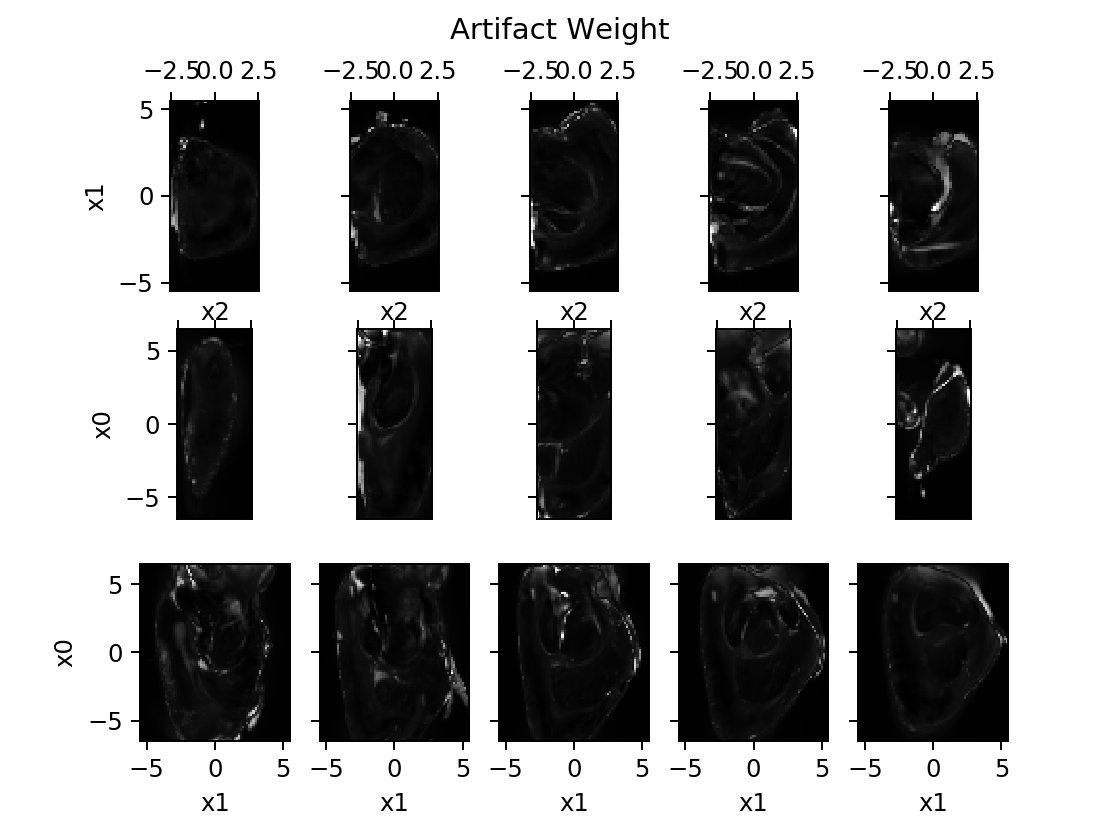

Taking affine and deformation step
Updating weights
Finished iteration 0, energy 4.976790e+01 (match 4.838699e+01, reg 1.380915e+00)
Taking affine and deformation step
Updating weights
Finished iteration 1, energy 3.315921e+01 (match 3.176392e+01, reg 1.395290e+00)
Taking affine and deformation step
Updating weights
Finished iteration 2, energy 3.292584e+01 (match 3.152233e+01, reg 1.403508e+00)
Taking affine and deformation step
Updating weights
Finished iteration 3, energy 3.284413e+01 (match 3.143274e+01, reg 1.411382e+00)
Taking affine and deformation step
Updating weights
Finished iteration 4, energy 3.278185e+01 (match 3.136285e+01, reg 1.419003e+00)
Taking affine and deformation step
Updating weights
Finished iteration 5, energy 3.272946e+01 (match 3.130306e+01, reg 1.426404e+00)
Taking affine and deformation step
Updating weights
Finished iteration 6, energy 3.268428e+01 (match 3.125067e+01, reg 1.433618e+00)
Taking affine and deformation step
Updating weights
Finished iteratio

Updating weights
Finished iteration 61, energy 3.156204e+01 (match 2.977412e+01, reg 1.787912e+00)
Taking affine and deformation step
Updating weights
Finished iteration 62, energy 3.154765e+01 (match 2.975331e+01, reg 1.794333e+00)
Taking affine and deformation step
Updating weights
Finished iteration 63, energy 3.153335e+01 (match 2.973259e+01, reg 1.800757e+00)
Taking affine and deformation step
Updating weights
Finished iteration 64, energy 3.151926e+01 (match 2.971208e+01, reg 1.807182e+00)
Taking affine and deformation step
Updating weights
Finished iteration 65, energy 3.150535e+01 (match 2.969174e+01, reg 1.813609e+00)
Taking affine and deformation step
Updating weights
Finished iteration 66, energy 3.149170e+01 (match 2.967166e+01, reg 1.820038e+00)
Taking affine and deformation step
Updating weights
Finished iteration 67, energy 3.147812e+01 (match 2.965165e+01, reg 1.826470e+00)
Taking affine and deformation step
Updating weights
Finished iteration 68, energy 3.146470e+01 (m

Updating weights
Finished iteration 122, energy 3.081792e+01 (match 2.863354e+01, reg 2.184383e+00)
Taking affine and deformation step
Updating weights
Finished iteration 123, energy 3.080742e+01 (match 2.861650e+01, reg 2.190926e+00)
Taking affine and deformation step
Updating weights
Finished iteration 124, energy 3.079703e+01 (match 2.859956e+01, reg 2.197467e+00)
Taking affine and deformation step
Updating weights
Finished iteration 125, energy 3.078682e+01 (match 2.858281e+01, reg 2.204005e+00)
Taking affine and deformation step
Updating weights
Finished iteration 126, energy 3.077662e+01 (match 2.856608e+01, reg 2.210541e+00)
Taking affine and deformation step
Updating weights
Finished iteration 127, energy 3.076648e+01 (match 2.854940e+01, reg 2.217075e+00)
Taking affine and deformation step
Updating weights
Finished iteration 128, energy 3.075641e+01 (match 2.853281e+01, reg 2.223605e+00)
Taking affine and deformation step
Updating weights
Finished iteration 129, energy 3.07463

Updating weights
Finished iteration 183, energy 3.028379e+01 (match 2.770340e+01, reg 2.580394e+00)
Taking affine and deformation step
Updating weights
Finished iteration 184, energy 3.027671e+01 (match 2.768988e+01, reg 2.586829e+00)
Taking affine and deformation step
Updating weights
Finished iteration 185, energy 3.026961e+01 (match 2.767635e+01, reg 2.593262e+00)
Taking affine and deformation step
Updating weights
Finished iteration 186, energy 3.026250e+01 (match 2.766280e+01, reg 2.599693e+00)
Taking affine and deformation step
Updating weights
Finished iteration 187, energy 3.025524e+01 (match 2.764912e+01, reg 2.606120e+00)
Taking affine and deformation step
Updating weights
Finished iteration 188, energy 3.024794e+01 (match 2.763540e+01, reg 2.612544e+00)
Taking affine and deformation step
Updating weights
Finished iteration 189, energy 3.024062e+01 (match 2.762166e+01, reg 2.618963e+00)
Taking affine and deformation step
Updating weights
Finished iteration 190, energy 3.02334

In [30]:
down = 2**ndown
niter = 200
naffine = 0


outd1 = lddmm.lddmm(Id,Jd,
                    xI=xId,xJ=xJd,
                    A0=outd2['A'],
                    vt00=outd2['vt0'], vt10=outd2['vt1'], vt20=outd2['vt2'],
                    niter=niter, naffine=naffine,
                    eT=eT*down, eL=eL*down,
                    nMstep=nMstep, nMstep_affine=nMstep_affine,
                    sigmaM=sigmaM,sigmaA=sigmaA,
                    sigmaR=sigmaR, eV=eV*down, a=a, nt=nt
                   )

# Deform the labels and check the quality

<IPython.core.display.Javascript object>


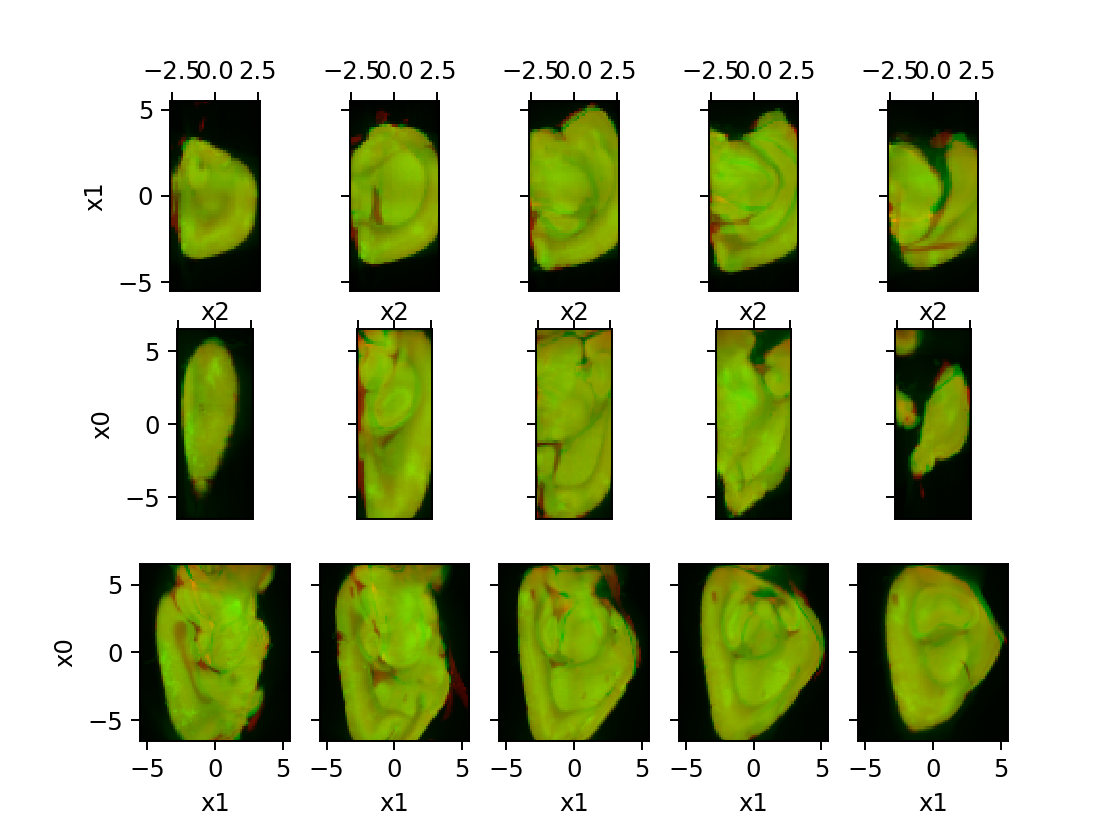

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7fa09414db38>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f9fda2fe6d8>]])

In [31]:
# display images for overlap
f = plt.figure()
vis.imshow_slices(vis.RGB_from_pair(outd1['AphiI'],Jd),x=xJ,fig=f)

In [32]:
# deform labels
nxL = L.shape
dxL = img_label.header['pixdim'][1:4]
xL = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxL,dxL)]
AphiL = lddmm.transform_data(*xL,L,
                            outd1['phiinvAinv0'],outd1['phiinvAinv1'],outd1['phiinvAinv2'],
                            y=xJ, # points to resample at
                            t=xJd, # points to define transform at 
                            method=0,image_dtype=tf.int32)


<IPython.core.display.Javascript object>


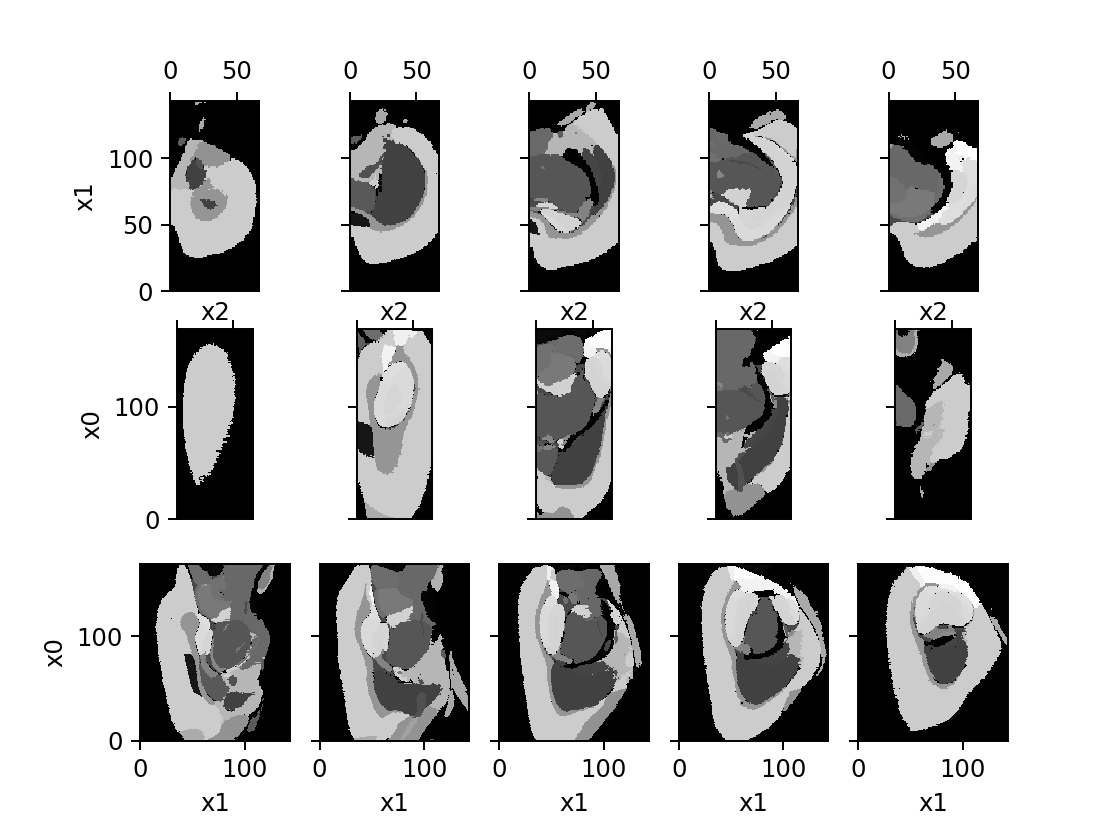

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7f9f784c20b8>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f9f7635b6a0>]])

In [33]:
f = plt.figure()
vis.imshow_slices(AphiL,fig=f)

In [34]:
AphiL.shape,Jd.shape,J.shape

((170, 144, 68), (85, 72, 34), (170, 144, 68))

<IPython.core.display.Javascript object>


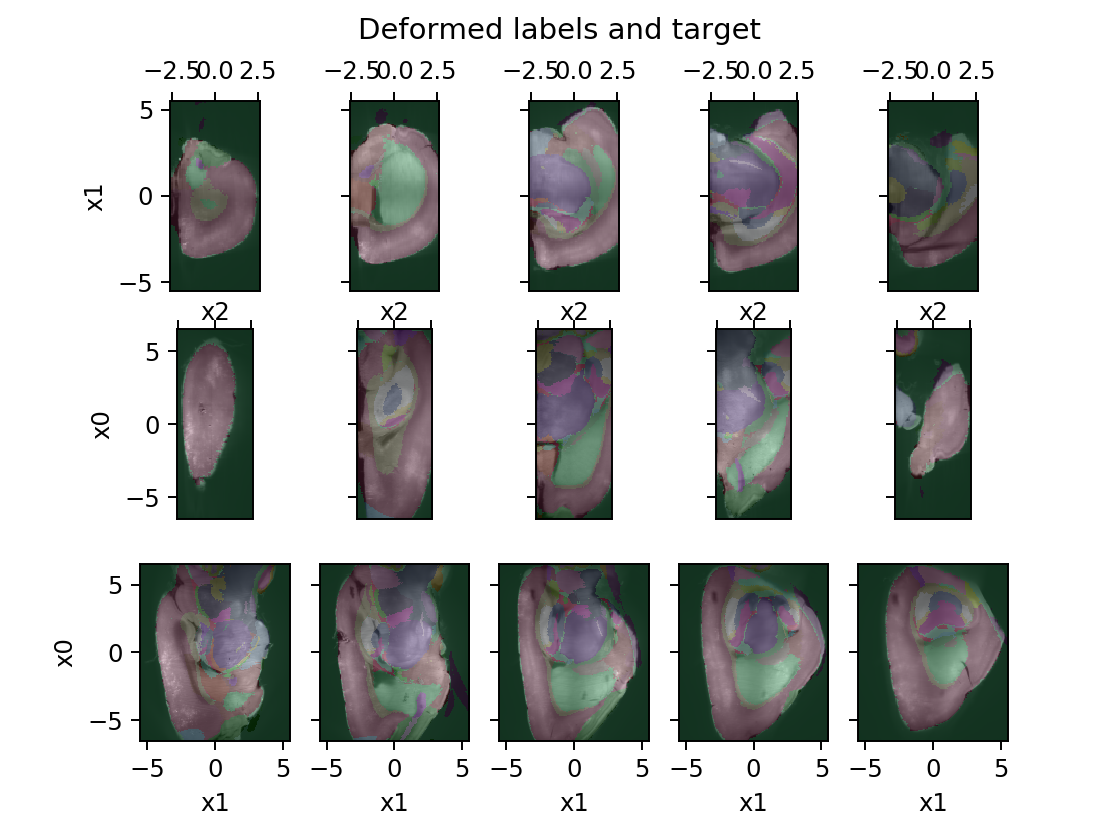

In [35]:
f = plt.figure()
vis.imshow_slices(vis.RGB_from_labels(AphiL,J,alpha=0.2),x=xJ,fig=f)
f.suptitle('Deformed labels and target')
f.canvas.draw()

In [36]:
AphiI = lddmm.transform_data(*xL,I0,
                            outd1['phiinvAinv0'],outd1['phiinvAinv1'],outd1['phiinvAinv2'],
                            y=xJ, # points to resample at
                            t=xJd, # points to define transform at 
                            )

<IPython.core.display.Javascript object>


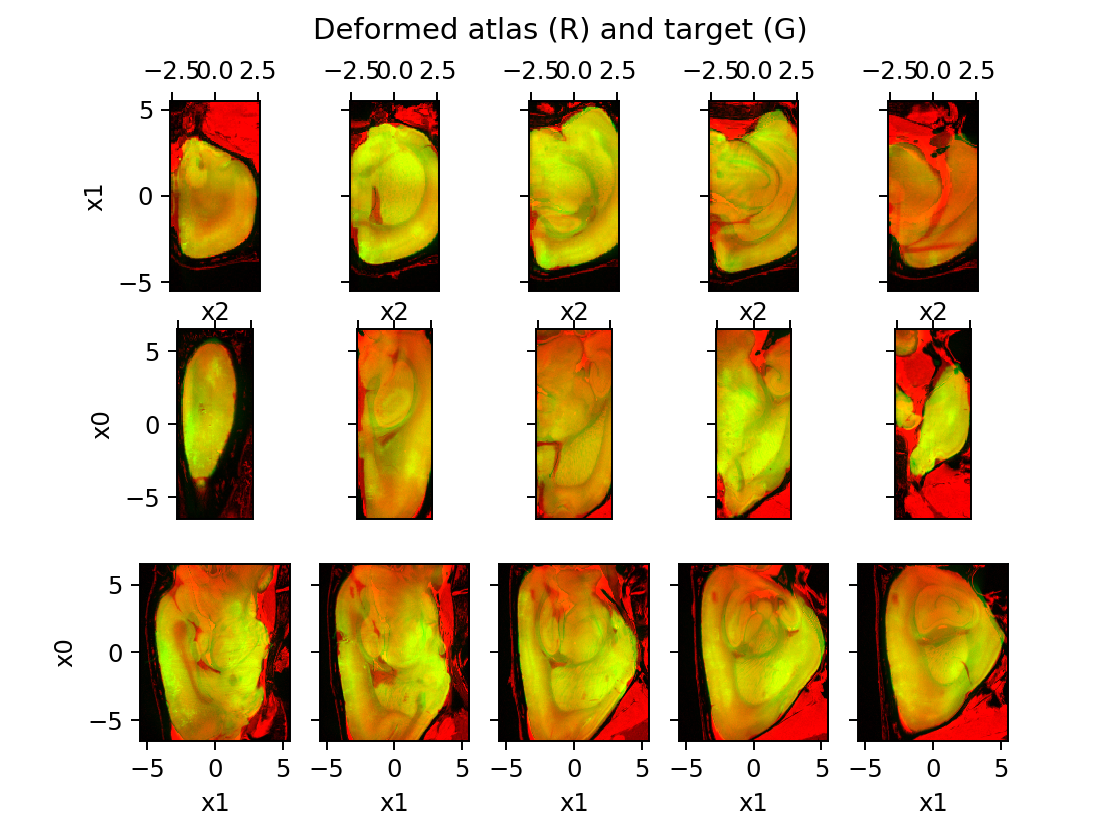

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [37]:
climJ = np.percentile(J,(1,99))
climI = np.percentile(AphiI,(1,95))
f = plt.figure()
vis.imshow_slices(vis.RGB_from_pair(AphiI,J,climI=climI,climJ=climJ),x=xJ,fig=f)
f.suptitle('Deformed atlas (R) and target (G)')
f.canvas.draw()


<IPython.core.display.Javascript object>


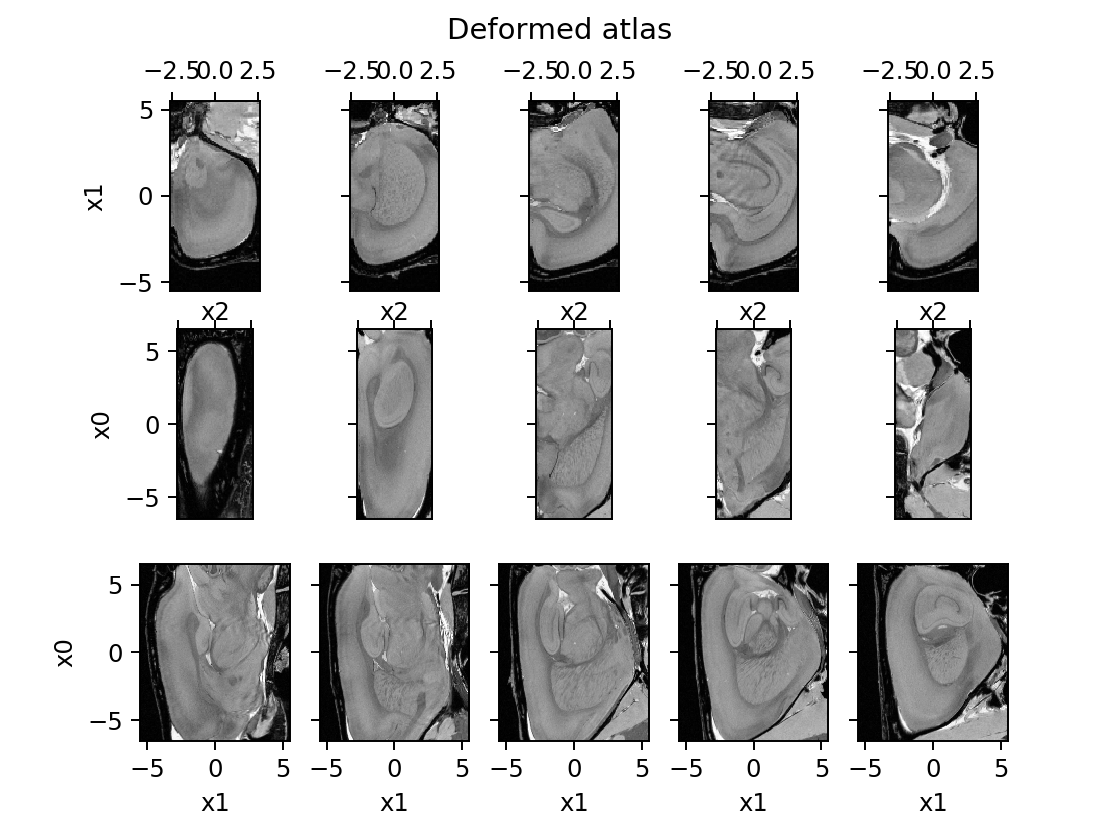

Text(0.5, 0.98, 'Deformed atlas')

In [38]:
f = plt.figure()
vis.imshow_slices(AphiI,x=xJ,fig=f)
f.suptitle('Deformed atlas')

<IPython.core.display.Javascript object>


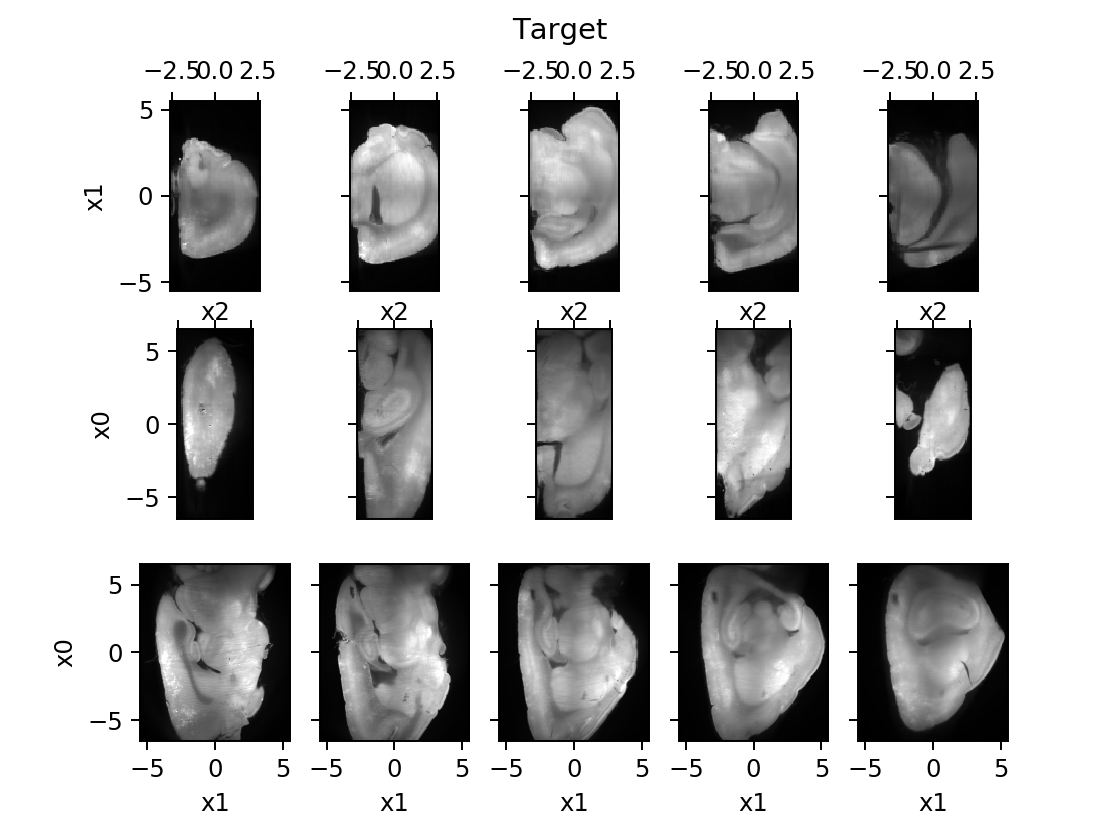

Text(0.5, 0.98, 'Target')

In [39]:
f = plt.figure()
vis.imshow_slices(J,x=xJ,fig=f)
f.suptitle('Target')

# Save the transformations

In [40]:
#np.savez(os.path.join())

# Now if the quality is good, write out the labels at high resolution

In [41]:
#J.shape,Jd.shape

In [42]:
#import scipy.interpolate as spi

In [43]:
#test = spi.interpn(xJd,outd1['phiinvAinv0'],np.stack((X0J,X1J,X2J),axis=-1))


In [44]:
#outd1['phiinvAinv0'].shape,xId[0].shape,Id.shape

# scratch